# Exploring Applications of A.I in Wealth Management: Customer Churn
### By: Nathan Chu, Cherry Yang, Matthew Yang, Cloris Zhang


In [ ]:
# File operations
import os

# Analytical libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

# Regex operations
import re

# Efficiency improvements
from joblib import parallel_backend

# Install necessary packages
!pip install category_encoders

# Encoders
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder

# Models we want to test
# from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier

# Test and train set splitting tool
from sklearn.model_selection import train_test_split

# Evaluation packages
from sklearn.metrics import accuracy_score,recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [ ]:
# Reading in the history dataset
history_df = pd.DataFrame()
file_path = 'history.csv'
if os.path.isfile(file_path) and os.path.getsize(file_path) > 0:
    history_df = pd.read_csv(file_path)
else:
    print("Error: The file is empty or does not exist.")

<ipython-input-82-b9b7cafff79e>:5: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  history_df = pd.read_csv(file_path)


In [ ]:
# Reading in the test dataset
test_df = pd.DataFrame()
file_path = 'test.csv'
if os.path.isfile(file_path) and os.path.getsize(file_path) > 0:
    test_df = pd.read_csv(file_path)
else:
    print("Error: The file is empty or does not exist.")

<ipython-input-139-741b99677478>:5: DtypeWarning: Columns (62,64,87) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(file_path)


In [ ]:
'''
@param df: A pandas DataFrame
@param cols: List of columns existing in df
@return: df with cols dropped
'''
def drop_cols(df, cols):
    df = df.drop(cols, axis=1)
    return df

In [ ]:
'''
@param df: A pandas DataFrame
@param cols: List of boolean columns in df
@return: df with the values in cols mapped to 0 (for False or blank) or 1 (for True)
'''
def boolean_map(df, cols):
    for col in cols:
        df[col] = df[col].fillna('f').map({'t': 1, 'f': 0})
    return df

In [ ]:
'''
@param df: A pandas DataFrame
@param cols: List of datetime columns in df
@return: df with the values in cols standardized to a number between 0 and 1.
'''
def parse_time(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col])
        min_date = df[col].min()
        df[col] = df[col].fillna(min_date)

        df[col] = df[col].astype(int)
        min = df[col].min()
        max = df[col].max()
        df[col] = (df[col] - min) / (max - min)

    return df

In [ ]:
'''
@param df: A pandas DataFrame
@param cols: List of object columns in df
@return: df with the values in cols mapped to arbitrary numbers
'''
def encode_test_data(df, testdf, cols):
    label_encoder = LabelEncoder()
    for col in cols:
        print(col)
        df[col] = df[col].fillna('missing')
        testdf[col] = testdf[col].fillna('missing')

        valid_data_train = df[col][df[col] != 'missing']
        valid_data_test = testdf[col][testdf[col] != 'missing']
        label_encoder.fit(valid_data_train)

        testdf[col] = testdf[col].apply(lambda x: x if x in label_encoder.classes_ else 'missing')

        df.loc[df[col] != 'missing', col] = label_encoder.transform(df[df[col] != 'missing'][col])
        testdf.loc[testdf[col] != 'missing', col] = label_encoder.transform(testdf[testdf[col] != 'missing'][col])

        df[col] = df[col].replace('missing', -999).astype(int)
        testdf[col] = testdf[col].replace('missing', -999).astype(int)

    return df, testdf

### 1.0 Drop unused columns

We do not want our model to be trained on data from any of these columns. The code looks a bit messy because we did this step in different ways.

In [ ]:
# Inclusion of specified columns
df_nathan = history_df[['id', 'type_code', 'class_id', 'inception_date', 'branch', 'include_client_consolidation', 'use_client_address', 'credit_limit_type', 'is_arp_locked', 'dividend_confirm_code']]

df_cloris = history_df[['options_trading_type', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'share_name_address_to_issuer', 'shareholder_instructions_received', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_spousal_transfer', 'terminal_code', 'deceased_fair_market_value', 'discretionary_trading_authorized']]

# Dropping unwanted columns
df_cherry = history_df.iloc[:, 52:79]
df_cherry = drop_cols(df_cherry, ['esir_number', 'dup_trip_quad_code', 'function_code', 'portfolio_cost_method','shareholder_language', 'interactive_portfolio_code', 'title', 'non_plan_book_value_flag', 'conjunction', 'portfolio_name_address_option', 'portfolio_summary_option'])

df_matthew = history_df.iloc[:, -27:]
df_matthew = drop_cols(df_matthew, ['is_broker_account', 'is_gl_account', 'is_control_account', 'is_plan_grandfathered'])

# Combining all data into one dataframe to use
training_df = pd.concat([df_nathan, df_cloris, df_cherry, df_matthew], axis=1)
training_df.head(3)

,id,type_code,class_id,inception_date,branch,include_client_consolidation,use_client_address,credit_limit_type,is_arp_locked,dividend_confirm_code,...,is_family_resp,is_hrdc_resp,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label
0,893724,CASH SWEEP,3.0,2017-08-18,IAVM,t,f,0.0,NaN,0.0,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,f,Churn
1,1268094,RRIF,5.0,2018-11-08,IAVM,t,t,0.0,f,0.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2023-01-03 00:00:00,BATCH,t,Churn
2,606613,SPOUSAL RRSP,5.0,2009-04-08,IAVM,f,f,0.0,f,0.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2018-07-17 00:00:00,GUERINO,f,Churn


### 1.1 Map Boolean Columns

In [ ]:
# Collecting all the columns that contain true or false and mapping the letters t and f to 1 and 0.
bool_nathan = ['include_client_consolidation', 'use_client_address', 'is_arp_locked']
bool_cloris = ['share_name_address_to_issuer', 'shareholder_instructions_received', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_spousal_transfer', 'discretionary_trading_authorized']
bool_cherry = ['receive_general_mailings', 'has_discrete_auth', 'is_non_objecting_beneficial_owner', 'is_objecting_to_disclose_info', 'consent_to_email_delivery', 'consent_to_pay_for_mail', 'has_received_instruction']
bool_matthew = ['is_inventory_account', 'is_extract_eligible', 'is_pledged', 'is_resp', 'is_family_resp', 'is_hrdc_resp'] + ['is_olob', 'visible_in_reports', 'use_original_date_for_payment_calc']

training_df = boolean_map(training_df, bool_nathan + bool_cloris + bool_cherry + bool_matthew)

### 1.2 Parse Datetime Columns

In [ ]:
# Collecintg all the columns that contain a datetime type and standardizing those values
time_nathan = ['inception_date']
time_cherry = ['last_update_date']
time_matthew = ['last_maintenance_time', 'plan_effective_date', 'plan_end_date', 'rrif_original_date', 'inserted_at', 'updated_at', 'retail_last_maintenance_time']

training_df = parse_time(training_df, time_nathan + time_cherry + time_matthew)

### 1.3 Numerize Type Columns

In [ ]:
# Replace 'NOT FOUND' with NaN in the 'special_tag' column
training_df['special_tag'] = training_df['special_tag'].replace('NOT FOUND', np.nan)

# Define a function to parse the risk tolerance string and convert it into a dictionary
def parse_risk_tolerance(rt_string):
    parts = re.findall(r'([L|M|Q|H])(\d{2})', rt_string)
    rt_dict = {'Low': 0, 'Medium': 0, 'Medium-High': 0, 'High': 0}
    for part in parts:
        if part[0] == 'L':
            rt_dict['Low'] = int(part[1])
        elif part[0] == 'M':
            rt_dict['Medium'] = int(part[1])
        elif part[0] == 'Q':
            rt_dict['Medium-High'] = int(part[1])
        elif part[0] == 'H':
            rt_dict['High'] = int(part[1])
    return rt_dict

# Define a function to parse the investment objective string and convert it into a dictionary
def parse_investment_objective(io_string):
    parts = re.findall(r'([B|C|D|G|M|S|X])(\d{2})', io_string)
    io_dict = {'Income': 0, 'Growth': 0, 'Speculative': 0, 'Liquidity': 0, 'Safety': 0}
    for part in parts:
        if part[0] == 'B':
            io_dict['Income'] = int(part[1])
        elif part[0] == 'C' or part[0] == 'G':
            io_dict['Growth'] += int(part[1])
        elif part[0] == 'D' or part[0] == 'S':
            io_dict['Speculative'] += int(part[1])
        elif part[0] == 'M':
            io_dict['Liquidity'] = int(part[1])
        elif part[0] == 'X':
            io_dict['Safety'] = int(part[1])
    return io_dict

# Apply the parsing functions to the 'risk_tolerance' and 'investment_objective' columns
training_df['risk_tolerance'] = training_df['risk_tolerance'].astype(str).apply(parse_risk_tolerance)
training_df['investment_objective'] = training_df['investment_objective'].astype(str).apply(parse_investment_objective)

# Define lists of columns for risk tolerance and investment objective
rt_columns = ['Low', 'Medium', 'Medium-High', 'High']
io_columns = ['Income', 'Growth', 'Speculative', 'Liquidity', 'Safety']

# Extract individual columns from dictionaries and add them to the DataFrame
for col in rt_columns:
    training_df[col] = training_df['risk_tolerance'].apply(lambda x: x[col])

for col in io_columns:
    training_df[col] = training_df['investment_objective'].apply(lambda x: x[col])

# Drop the original 'risk_tolerance' and 'investment_objective' columns
training_df.drop(['risk_tolerance', 'investment_objective'], axis=1, inplace=True)
training_df.head()

,id,type_code,class_id,inception_date,branch,include_client_consolidation,use_client_address,credit_limit_type,is_arp_locked,dividend_confirm_code,...,label,Low,Medium,Medium-High,High,Income,Growth,Speculative,Liquidity,Safety
0,893724,CASH SWEEP,3.0,0.808752,IAVM,1,0,0.0,0,0.0,...,Churn,0,0,0,0,0,0,0,0,0
1,1268094,RRIF,5.0,0.847716,IAVM,1,1,0.0,0,0.0,...,Churn,0,90,0,10,5,85,10,0,0
2,606613,SPOUSAL RRSP,5.0,0.542538,IAVM,0,0,0.0,0,0.0,...,Churn,0,50,0,50,0,50,50,0,0
3,741930,CASH,3.0,0.916405,IAVM,1,1,0.0,0,0.0,...,Churn,0,99,0,0,0,99,0,0,0
4,1137922,CASH,3.0,0.806311,IAVM,1,0,0.0,0,0.0,...,Churn,0,99,0,0,0,99,0,0,0


### 1.4 Other

In [ ]:
# Filling in empty values with a standardized value across all columns we use that contain them

training_df.class_id.fillna(-999, inplace=True)
training_df.credit_limit_type.fillna(-999, inplace=True)
training_df.dividend_confirm_code.fillna(-999, inplace=True)
training_df.deceased_fair_market_value.fillna(0, inplace=True)
training_df.options_trading_type.fillna(-999, inplace=True)
training_df.interest_dividend_conversion_type.fillna(-999, inplace=True)
training_df.guarantee_gtor_type.fillna(-999, inplace=True)
training_df.number_of_beneficiaries.fillna(0, inplace=True)
training_df.label = training_df.label.map({'No Churn': 0, 'Churn': 1})

training_df

,id,type_code,class_id,inception_date,branch,include_client_consolidation,use_client_address,credit_limit_type,is_arp_locked,dividend_confirm_code,...,label,Low,Medium,Medium-High,High,Income,Growth,Speculative,Liquidity,Safety
0,893724,CASH SWEEP,3.0,0.808752,IAVM,1,0,0.0,0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,1268094,RRIF,5.0,0.847716,IAVM,1,1,0.0,0,0.0,...,1,0,90,0,10,5,85,10,0,0
2,606613,SPOUSAL RRSP,5.0,0.542538,IAVM,0,0,0.0,0,0.0,...,1,0,50,0,50,0,50,50,0,0
3,741930,CASH,3.0,0.916405,IAVM,1,1,0.0,0,0.0,...,1,0,99,0,0,0,99,0,0,0
4,1137922,CASH,3.0,0.806311,IAVM,1,0,0.0,0,0.0,...,1,0,99,0,0,0,99,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,6827067,LIRA/LRSP/RLSP,5.0,0.995206,HOLIS,1,1,0.0,1,0.0,...,1,0,99,0,0,0,99,0,0,0
673335,590659,REG RRSP,5.0,0.466963,IAVM,1,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
673336,1247774,CASH,3.0,0.873431,IAVM,1,1,0.0,0,0.0,...,1,0,75,0,25,0,99,0,0,0
673337,1155640,RRIF,5.0,0.806311,IAVM,1,1,0.0,0,0.0,...,1,0,99,0,0,0,99,0,0,0


In [ ]:
# Collecting all categorical columns which we've decided to use to encode using label encoding
type_nathan = ['type_code', 'branch']
type_cloris = ['terminal_code']
type_matthew = ['last_maintenance_user', 'retail_last_maintenance_user']
type_cherry = ['iso_funds_code', 'special_tag', 'tms_settlement_location', 'portfolio_report_option', 'loan_limit_override']

training_df, test_df = encode_test_data(training_df, test_df, type_nathan + type_cloris + type_matthew + type_cherry)
training_df

type_code
branch
terminal_code
last_maintenance_user
retail_last_maintenance_user
iso_funds_code
special_tag
tms_settlement_location
portfolio_report_option
loan_limit_override


,id,type_code,class_id,inception_date,branch,include_client_consolidation,use_client_address,credit_limit_type,is_arp_locked,dividend_confirm_code,...,label,Low,Medium,Medium-High,High,Income,Growth,Speculative,Liquidity,Safety
0,893724,2,3.0,0.808752,6,1,0,0.0,0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,1268094,16,5.0,0.847716,6,1,1,0.0,0,0.0,...,1,0,90,0,10,5,85,10,0,0
2,606613,19,5.0,0.542538,6,0,0,0.0,0,0.0,...,1,0,50,0,50,0,50,50,0,0
3,741930,1,3.0,0.916405,6,1,1,0.0,0,0.0,...,1,0,99,0,0,0,99,0,0,0
4,1137922,1,3.0,0.806311,6,1,0,0.0,0,0.0,...,1,0,99,0,0,0,99,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,6827067,9,5.0,0.995206,3,1,1,0.0,1,0.0,...,1,0,99,0,0,0,99,0,0,0
673335,590659,14,5.0,0.466963,6,1,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
673336,1247774,1,3.0,0.873431,6,1,1,0.0,0,0.0,...,1,0,75,0,25,0,99,0,0,0
673337,1155640,16,5.0,0.806311,6,1,1,0.0,0,0.0,...,1,0,99,0,0,0,99,0,0,0


### 2.0 Exploratory Data Analysis


In [ ]:
# For A to AZ
a_az_df = training_df.iloc[:, 0:21]
a_az_df = drop_cols(a_az_df, ['id', 'include_client_consolidation', 'use_client_address', 'dividend_confirm_code', 'share_name_address_to_issuer', 'shareholder_instructions_received', 'is_tms_eligible', 'is_agent_bbs_participant'])

# First 5 observations
a_az_df.head()

,type_code,class_id,inception_date,branch,credit_limit_type,is_arp_locked,options_trading_type,interest_dividend_conversion_type,guarantee_gtor_type,is_spousal_transfer,terminal_code,deceased_fair_market_value,discretionary_trading_authorized
0,1,3.0,0.808752,5,0.0,0,0.0,0.0,0.0,0,-999,0.0,0
1,15,5.0,0.847716,5,0.0,0,0.0,0.0,2.0,0,719,0.0,0
2,18,5.0,0.542538,5,0.0,0,0.0,0.0,2.0,0,755,0.0,0
3,0,3.0,0.916405,5,0.0,0,0.0,0.0,0.0,0,316,0.0,0
4,0,3.0,0.806311,5,0.0,0,0.0,0.0,0.0,0,719,0.0,0


In [ ]:
# For BA to CZ
df_eda = training_df.iloc[:, 21:67]
df_eda.head()

,iso_funds_code,special_tag,tms_settlement_location,portfolio_report_option,receive_general_mailings,loan_limit_override,has_discrete_auth,last_update_date,is_non_objecting_beneficial_owner,is_objecting_to_disclose_info,...,label,Low,Medium,Medium-High,High,Income,Growth,Speculative,Liquidity,Safety
0,0,-999,-999,0,1,-999,0,0.000000,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,-999,-999,0,1,-999,0,0.953032,1,0,...,1,0,90,0,10,5,85,10,0,0
2,0,-999,-999,0,1,-999,0,0.538847,0,1,...,1,0,50,0,50,0,50,50,0,0
3,0,-999,-999,0,1,-999,0,0.870195,1,0,...,1,0,99,0,0,0,99,0,0,0
4,0,-999,-999,0,1,-999,0,0.699648,0,1,...,1,0,99,0,0,0,99,0,0,0


### 2.1 General Data Info


In [ ]:
# Summary of dataframe's composition
a_az_df.info()
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673339 entries, 0 to 673338
Data columns (total 13 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   type_code                          673339 non-null  int64  
 1   class_id                           673339 non-null  float64
 2   inception_date                     673339 non-null  float64
 3   branch                             673339 non-null  int64  
 4   credit_limit_type                  673339 non-null  float64
 5   is_arp_locked                      673339 non-null  int64  
 6   options_trading_type               673339 non-null  float64
 7   interest_dividend_conversion_type  673339 non-null  float64
 8   guarantee_gtor_type                673339 non-null  float64
 9   is_spousal_transfer                673339 non-null  int64  
 10  terminal_code                      673339 non-null  int64  
 11  deceased_fair_market_value         6733

In [ ]:
# To generate descriptive statistics of our data set
print ('for A to AZ')
a_az_df.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

for A to AZ


,type_code,class_id,inception_date,branch,credit_limit_type,is_arp_locked,options_trading_type,interest_dividend_conversion_type,guarantee_gtor_type,is_spousal_transfer,terminal_code,deceased_fair_market_value,discretionary_trading_authorized
count,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000
mean,8.325823,-0.326501,0.801163,-0.249815,-4.744078,0.042898,-4.690759,-4.742394,-3.599377,0.000184,453.284542,2.172825,0.021162
std,20.339038,69.059302,0.135758,69.002734,68.683892,0.202628,68.688458,68.683985,68.770445,0.013569,616.043989,46.320385,0.143923
min,-999.000000,-999.000000,0.000000,-999.000000,-999.000000,0.000000,-999.000000,-999.000000,-999.000000,0.000000,-999.000000,0.000000,0.000000
5%,0.000000,3.000000,0.521705,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,0.000000,0.000000
25%,0.000000,3.000000,0.806311,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,173.000000,0.000000,0.000000
50%,10.000000,5.000000,0.806311,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,719.000000,0.000000,0.000000
75%,15.000000,5.000000,0.872167,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,748.000000,0.000000,0.000000
90%,19.000000,5.000000,0.946043,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1051.000000,0.000000,0.000000
95%,19.000000,5.000000,0.974372,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1191.000000,0.000000,0.000000


In [ ]:
print ('for BA to CZ')
df_eda.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

for BA to CZ


,iso_funds_code,special_tag,tms_settlement_location,portfolio_report_option,receive_general_mailings,loan_limit_override,has_discrete_auth,last_update_date,is_non_objecting_beneficial_owner,is_objecting_to_disclose_info,...,label,Low,Medium,Medium-High,High,Income,Growth,Speculative,Liquidity,Safety
count,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.0,673339.000000,673339.000000,673339.000000,...,673339.000000,673339.000000,673339.000000,673339.0,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000
mean,-4.688046,-929.842620,-987.408603,-4.744696,0.995157,-952.745440,0.0,0.642163,0.435102,0.401062,...,0.799663,6.917673,54.797332,0.0,16.136998,8.987348,55.411895,10.138513,3.390350,0.005418
std,68.688112,254.121725,107.429143,68.683810,0.069423,210.036043,0.0,0.332128,0.495771,0.490114,...,0.400253,21.433002,40.803495,0.0,26.355602,18.537370,40.957597,23.068542,17.353538,0.593080
min,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,-999.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,0.000000,-999.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-999.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.501760,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-999.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.752978,0.000000,0.000000,...,1.000000,0.000000,70.000000,0.0,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000
75%,0.000000,-999.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.891310,1.000000,1.000000,...,1.000000,0.000000,95.000000,0.0,20.000000,10.000000,99.000000,10.000000,0.000000,0.000000
90%,0.000000,-999.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.956416,1.000000,1.000000,...,1.000000,20.000000,99.000000,0.0,50.000000,35.000000,99.000000,34.000000,0.000000,0.000000
95%,1.000000,4.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.976719,1.000000,1.000000,...,1.000000,50.000000,99.000000,0.0,99.000000,50.000000,99.000000,50.000000,2.000000,0.000000


In [ ]:
# Categorical Variables
categorical_variables_a = [col for col in a_az_df.columns if a_az_df[col].nunique() <= 50
                        and col not in "label"]
print ('for A to AZ')
print(categorical_variables_a)

for A to AZ
['type_code', 'branch', 'credit_limit_type', 'is_arp_locked', 'options_trading_type', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'is_spousal_transfer', 'discretionary_trading_authorized']


In [ ]:
# Categorical Variables
categorical_variables_ba = [col for col in df_eda.columns if df_eda[col].nunique() <= 50
                        and col not in "label"]
print ('for BA to CZ')
print(categorical_variables_ba)

for BA to CZ
['iso_funds_code', 'special_tag', 'tms_settlement_location', 'portfolio_report_option', 'receive_general_mailings', 'loan_limit_override', 'has_discrete_auth', 'is_non_objecting_beneficial_owner', 'is_objecting_to_disclose_info', 'mailing_consent', 'consent_to_pay_for_mail', 'consent_to_email_delivery', 'has_received_instruction', 'is_inventory_account', 'is_extract_eligible', 'is_pledged', 'special_fee_code', 'non_calendar_year_end', 'is_resp', 'number_of_beneficiaries', 'use_original_date_for_payment_calc', 'is_family_resp', 'is_hrdc_resp', 'resp_specimen_plan', 'is_olob', 'visible_in_reports', 'Medium-High', 'Liquidity', 'Safety']


In [ ]:
# Numerical Variables
numeric_variables_a = [col for col in a_az_df.columns if a_az_df[col].dtype != "object"
                        and a_az_df[col].nunique() >50]
print ('for A to AZ')
print(numeric_variables_a)

for A to AZ
['class_id', 'inception_date', 'terminal_code', 'deceased_fair_market_value']


In [ ]:
# Numerical Variables
numeric_variables_ba = [col for col in df_eda.columns if df_eda[col].dtype != "object"
                        and df_eda[col].nunique() >50]
print ('for BA to CZ')
print(numeric_variables_ba)

for BA to CZ
['last_update_date', 'last_maintenance_time', 'last_maintenance_user', 'plan_effective_date', 'plan_end_date', 'rrif_original_date', 'inserted_at', 'updated_at', 'retail_last_maintenance_time', 'retail_last_maintenance_user', 'Low', 'Medium', 'High', 'Income', 'Growth', 'Speculative']


In [ ]:
# Rearrange certain variables
categorical_variables_ba.append('last_maintenance_user')
categorical_variables_ba.append('retail_last_maintenance_user')
categorical_variables_ba.remove('Medium-High')
categorical_variables_ba.remove('Liquidity')
categorical_variables_ba.remove('Safety')

numeric_variables_ba.remove('last_maintenance_user')
numeric_variables_ba.remove('retail_last_maintenance_user')
numeric_variables_ba.append('Medium-High')
numeric_variables_ba.append('Liquidity')
numeric_variables_ba.append('Safety')

numeric_variables_a.remove('class_id')
categorical_variables_a.append('class_id')
numeric_variables_a.remove('terminal_code')
categorical_variables_a.append('terminal_code')


### 2.2 Dependent Variable (Churn or No Churn)

In [ ]:
# Frequency of classes of our dependent variable, where 1 - Churn, 0 - No Churn
training_df["label"].value_counts()

1    538444
0    134895
Name: label, dtype: int64

In [ ]:
# Customers who churned
churn_df = training_df.loc[training_df['label'] == 1]

In [ ]:
# Customers who did not churn
no_churn_df = training_df.loc[training_df['label'] == 0]

### 2.3 Categorical Variables

In [ ]:
# Function to summarize distributions of categories within each feature corresponding to Churn or No Churn
def eda_func_cat(col_name):
  print('-----------' + col_name + '-----------')

  # For churn
  print('Churn:')
  churn_counts = churn_df[col_name].value_counts().sort_values()
  churn_percentages = churn_df[col_name].value_counts(normalize=True).sort_values() * 100  # calculates percentages
  for index, value in churn_counts.iteritems():
      print(f"{index}: {value} ({churn_percentages[index]:.2f}%)")

  # For no churn
  print('\nNo Churn:')
  no_churn_counts = no_churn_df[col_name].value_counts().sort_values()
  no_churn_percentages = no_churn_df[col_name].value_counts(normalize=True).sort_values() * 100  # calculates percentages
  for index, value in no_churn_counts.iteritems():
      print(f"{index}: {value} ({no_churn_percentages[index]:.2f}%)")

In [ ]:
# Analysis for categorical variables
for col in categorical_variables_a:
    eda_func_cat(col)

-----------type_code-----------
Churn:
6: 6 (0.00%)
4: 30 (0.01%)
-999: 236 (0.04%)
2: 248 (0.05%)
7: 263 (0.05%)
5: 445 (0.08%)
12: 931 (0.17%)
16: 1583 (0.29%)
9: 3198 (0.59%)
17: 6149 (1.14%)
3: 7748 (1.44%)
11: 7984 (1.48%)
18: 11453 (2.13%)
14: 13663 (2.54%)
8: 16201 (3.01%)
15: 26281 (4.88%)
10: 32089 (5.96%)
13: 65843 (12.23%)
19: 72998 (13.56%)
1: 80296 (14.91%)
0: 190799 (35.44%)

No Churn:
-999: 1 (0.00%)
2: 1 (0.00%)
16: 1 (0.00%)
6: 5 (0.00%)
1: 11 (0.01%)
0: 12 (0.01%)
10: 26 (0.02%)
7: 150 (0.11%)
12: 206 (0.15%)
17: 2829 (2.10%)
11: 3998 (2.96%)
14: 9063 (6.72%)
18: 10432 (7.73%)
8: 12089 (8.96%)
15: 12621 (9.36%)
19: 35075 (26.00%)
13: 48375 (35.86%)
-----------branch-----------
Churn:
6: 1 (0.00%)
7: 70 (0.01%)
3: 320 (0.06%)
1: 655 (0.12%)
8: 2905 (0.54%)
-999: 3198 (0.59%)
0: 4101 (0.76%)
2: 53511 (9.94%)
4: 79888 (14.84%)
5: 393795 (73.14%)

No Churn:
7: 6 (0.00%)
3: 31 (0.02%)
1: 403 (0.30%)
8: 1206 (0.89%)
0: 3767 (2.79%)
2: 12169 (9.02%)
4: 15397 (11.41%)
5: 1019

<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is depreca


1: 5159 (3.82%)
0: 129736 (96.18%)
-----------class_id-----------
Churn:
20.0: 1 (0.00%)
41.0: 1 (0.00%)
50.0: 1 (0.00%)
51.0: 1 (0.00%)
25.0: 1 (0.00%)
43.0: 1 (0.00%)
13.0: 1 (0.00%)
62.0: 1 (0.00%)
63.0: 1 (0.00%)
38.0: 2 (0.00%)
4.0: 2 (0.00%)
40.0: 2 (0.00%)
44.0: 2 (0.00%)
34.0: 2 (0.00%)
47.0: 2 (0.00%)
59.0: 2 (0.00%)
27.0: 3 (0.00%)
49.0: 3 (0.00%)
35.0: 3 (0.00%)
54.0: 3 (0.00%)
67.0: 3 (0.00%)
16.0: 3 (0.00%)
32.0: 3 (0.00%)
71.0: 4 (0.00%)
17.0: 4 (0.00%)
15.0: 4 (0.00%)
65.0: 4 (0.00%)
53.0: 4 (0.00%)
23.0: 5 (0.00%)
39.0: 5 (0.00%)
61.0: 5 (0.00%)
57.0: 6 (0.00%)
42.0: 6 (0.00%)
36.0: 6 (0.00%)
52.0: 9 (0.00%)
19.0: 10 (0.00%)
70.0: 12 (0.00%)
58.0: 15 (0.00%)
9.0: 15 (0.00%)
48.0: 17 (0.00%)
26.0: 17 (0.00%)
74.0: 20 (0.00%)
24.0: 27 (0.01%)
18.0: 35 (0.01%)
33.0: 37 (0.01%)
22.0: 47 (0.01%)
31.0: 57 (0.01%)
12.0: 83 (0.02%)
75.0: 105 (0.02%)
14.0: 120 (0.02%)
11.0: 122 (0.02%)
28.0: 160 (0.03%)
21.0: 249 (0.05%)
60.0: 251 (0.05%)
56.0: 697 (0.13%)
30.0: 1329 (0.25%)
29

<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():


1349: 89 (0.02%)
538: 89 (0.02%)
1237: 89 (0.02%)
1252: 90 (0.02%)
527: 90 (0.02%)
517: 90 (0.02%)
1281: 90 (0.02%)
261: 91 (0.02%)
525: 91 (0.02%)
583: 91 (0.02%)
594: 91 (0.02%)
279: 91 (0.02%)
1034: 92 (0.02%)
1226: 92 (0.02%)
519: 92 (0.02%)
1195: 92 (0.02%)
1025: 92 (0.02%)
496: 93 (0.02%)
518: 93 (0.02%)
272: 93 (0.02%)
1055: 94 (0.02%)
1295: 94 (0.02%)
513: 94 (0.02%)
498: 94 (0.02%)
1008: 94 (0.02%)
999: 95 (0.02%)
1294: 95 (0.02%)
541: 95 (0.02%)
1310: 96 (0.02%)
1263: 96 (0.02%)
476: 96 (0.02%)
1229: 96 (0.02%)
991: 97 (0.02%)
1071: 97 (0.02%)
1001: 98 (0.02%)
1185: 98 (0.02%)
314: 98 (0.02%)
1200: 99 (0.02%)
1275: 99 (0.02%)
256: 100 (0.02%)
258: 100 (0.02%)
1257: 100 (0.02%)
1026: 100 (0.02%)
203: 101 (0.02%)
570: 101 (0.02%)
1308: 102 (0.02%)
565: 102 (0.02%)
1277: 102 (0.02%)
1070: 102 (0.02%)
529: 102 (0.02%)
1117: 102 (0.02%)
502: 102 (0.02%)
490: 102 (0.02%)
443: 103 (0.02%)
504: 103 (0.02%)
488: 103 (0.02%)
981: 103 (0.02%)
994: 103 (0.02%)
979: 103 (0.02%)
1319: 104 

<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():


In [ ]:
# Analysis for categorical variables
for col in categorical_variables_ba:
    eda_func_cat(col)

<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():


-----------iso_funds_code-----------
Churn:
-999: 3198 (0.59%)
1: 36060 (6.70%)
0: 499186 (92.71%)

No Churn:
1: 2098 (1.56%)
0: 132797 (98.44%)
-----------special_tag-----------
Churn:
7: 11 (0.00%)
0: 11 (0.00%)
6: 44 (0.01%)
2: 59 (0.01%)
1: 300 (0.06%)
5: 411 (0.08%)
3: 2169 (0.40%)
4: 39131 (7.27%)
-999: 496308 (92.17%)

No Churn:
7: 1 (0.00%)
6: 3 (0.00%)
5: 5 (0.00%)
0: 6 (0.00%)
1: 16 (0.01%)
3: 172 (0.13%)
4: 4091 (3.03%)
-999: 130601 (96.82%)
-----------tms_settlement_location-----------
Churn:
3: 2 (0.00%)
2: 3 (0.00%)
8: 4 (0.00%)
9: 7 (0.00%)
10: 9 (0.00%)
11: 9 (0.00%)
13: 10 (0.00%)
6: 12 (0.00%)
0: 137 (0.03%)
4: 138 (0.03%)
5: 145 (0.03%)
7: 360 (0.07%)
1: 2142 (0.40%)
12: 4771 (0.89%)
-999: 530695 (98.56%)

No Churn:
-999: 134895 (100.00%)
-----------portfolio_report_option-----------
Churn:
1: 1 (0.00%)
2: 2 (0.00%)
3: 2 (0.00%)
-999: 3198 (0.59%)
0: 535241 (99.41%)

No Churn:


<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is depreca

2: 1 (0.00%)
0: 134894 (100.00%)
-----------receive_general_mailings-----------
Churn:
0: 3250 (0.60%)
1: 535194 (99.40%)

No Churn:
0: 11 (0.01%)
1: 134884 (99.99%)
-----------loan_limit_override-----------
Churn:
2: 1 (0.00%)
0: 2 (0.00%)
1: 31079 (5.77%)
-999: 507362 (94.23%)

No Churn:
1: 63 (0.05%)
-999: 134832 (99.95%)
-----------has_discrete_auth-----------
Churn:
0: 538444 (100.00%)

No Churn:
0: 134895 (100.00%)
-----------is_non_objecting_beneficial_owner-----------
Churn:
1: 230220 (42.76%)
0: 308224 (57.24%)

No Churn:


<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is depreca

1: 62751 (46.52%)
0: 72144 (53.48%)
-----------is_objecting_to_disclose_info-----------
Churn:
1: 207643 (38.56%)
0: 330801 (61.44%)

No Churn:
1: 62408 (46.26%)


<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():


0: 72487 (53.74%)
-----------mailing_consent-----------
Churn:
1.0: 3344 (0.62%)
0.0: 531902 (99.38%)

No Churn:
1.0: 1137 (0.84%)
0.0: 133758 (99.16%)
-----------consent_to_pay_for_mail-----------
Churn:
1: 51028 (9.48%)
0: 487416 (90.52%)

No Churn:
1: 22061 (16.35%)
0: 112834 (83.65%)
-----------consent_to_email_delivery-----------
Churn:


<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():


1: 122 (0.02%)
0: 538322 (99.98%)

No Churn:
1: 27 (0.02%)
0: 134868 (99.98%)
-----------has_received_instruction-----------
Churn:
0: 101508 (18.85%)
1: 436936 (81.15%)

No Churn:
0: 10040 (7.44%)
1: 124855 (92.56%)
-----------is_inventory_account-----------
Churn:
1: 103 (0.02%)
0: 538341 (99.98%)

No Churn:
0: 134895 (100.00%)
-----------is_extract_eligible-----------
Churn:
0: 3267 (0.61%)
1: 535177 (99.39%)

No Churn:
0: 69 (0.05%)
1: 134826 (99.95%)
-----------is_pledged-----------
Churn:
1: 2 (0.00%)
0: 538442 (100.00%)

No Churn:
1: 1 (0.00%)
0: 134894 (100.00%)
-----------special_fee_code-----------
Churn:
BR: 1 (2.63%)
EN: 1 (2.63%)
ZE: 1 (2.63%)
2: 1 (2.63%)
4.0: 1 (2.63%)
/S: 1 (2.63%)
E: 1 (2.63%)
NE: 1 (2.63%)
0.0: 1 (2.63%)
RO: 1 (2.63%)
9.0: 1 (2.63%)
RR: 1 (2.63%)
DF: 1 (2.63%)
7.0: 1 (2.63%)
B: 1 (2.63%)
OR: 1 (2.63%)
87.0: 1 (2.63%)
19.0: 1 (2.63%)
3.0: 2 (5.26%)
8.0: 2 (5.26%)
6.0: 2 (5.26%)
3.0: 2 (5.26%)
1.0: 3 (7.89%)
N: 3 (7.89%)
2.0: 3 (7.89%)
5.0: 3 (7.89%)

N

<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is depreca

0.0: 1 (0.00%)
0: 497 (0.37%)
00/0: 40413 (29.97%)
0000: 93945 (69.66%)
-----------is_resp-----------
Churn:
1: 13677 (2.54%)
0: 524767 (97.46%)

No Churn:
1: 9067 (6.72%)
0: 125828 (93.28%)
-----------number_of_beneficiaries-----------
Churn:
15.0: 1 (0.00%)
10.0: 1 (0.00%)
9.0: 3 (0.00%)
8.0: 4 (0.00%)
7.0: 9 (0.00%)
6.0: 14 (0.00%)
5.0: 66 (0.01%)
4.0: 332 (0.06%)
3.0: 1689 (0.31%)
2.0: 5742 (1.07%)
1.0: 5793 (1.08%)
0.0: 524790 (97.46%)

No Churn:
24.0: 1 (0.00%)
8.0: 4 (0.00%)
9.0: 4 (0.00%)
7.0: 4 (0.00%)
6.0: 13 (0.01%)
5.0: 41 (0.03%)
4.0: 246 (0.18%)
3.0: 1079 (0.80%)
2.0: 3691 (2.74%)
1.0: 3981 (2.95%)
0.0: 125831 (93.28%)
-----------use_original_date_for_payment_calc-----------
Churn:
1: 13651 (2.54%)
0: 524793 (97.46%)

No Churn:
1: 9016 (6.68%)
0: 125879 (93.32%)
-----------is_family_resp-----------
Churn:
1: 10262 (1.91%)
0: 528182 (98.09%)

No Churn:
1: 6438 (4.77%)
0: 128457 (95.23%)
-----------is_hrdc_resp-----------
Churn:
1: 13336 (2.48%)
0: 525108 (97.52%)

No Churn

<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is depreca

219: 16 (0.00%)
372: 17 (0.00%)
328: 17 (0.00%)
292: 17 (0.00%)
29: 18 (0.00%)
277: 19 (0.00%)
3: 19 (0.00%)
235: 19 (0.00%)
187: 19 (0.00%)
374: 20 (0.00%)
21: 20 (0.00%)
135: 21 (0.00%)
30: 21 (0.00%)
185: 22 (0.00%)
59: 22 (0.00%)
315: 22 (0.00%)
15: 23 (0.00%)
40: 23 (0.00%)
441: 25 (0.00%)
256: 25 (0.00%)
171: 27 (0.01%)
85: 27 (0.01%)
357: 27 (0.01%)
191: 27 (0.01%)
6: 29 (0.01%)
14: 29 (0.01%)
178: 31 (0.01%)
8: 32 (0.01%)
145: 33 (0.01%)
62: 33 (0.01%)
302: 34 (0.01%)
283: 34 (0.01%)
271: 35 (0.01%)
433: 35 (0.01%)
50: 35 (0.01%)
64: 36 (0.01%)
207: 38 (0.01%)
68: 39 (0.01%)
82: 39 (0.01%)
42: 40 (0.01%)
89: 41 (0.01%)
173: 42 (0.01%)
1: 42 (0.01%)
172: 42 (0.01%)
208: 43 (0.01%)
299: 46 (0.01%)
4: 46 (0.01%)
429: 49 (0.01%)
39: 49 (0.01%)
340: 52 (0.01%)
186: 52 (0.01%)
416: 54 (0.01%)
66: 56 (0.01%)
296: 58 (0.01%)
222: 59 (0.01%)
383: 64 (0.01%)
63: 64 (0.01%)
365: 64 (0.01%)
128: 65 (0.01%)
394: 71 (0.01%)
423: 73 (0.01%)
263: 75 (0.01%)
428: 76 (0.01%)
370: 78 (0.01%)
289:

<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():


74: 1 (0.00%)
295: 1 (0.00%)
24: 1 (0.00%)
78: 1 (0.00%)
293: 1 (0.00%)
33: 1 (0.00%)
148: 1 (0.00%)
283: 1 (0.00%)
237: 1 (0.00%)
34: 1 (0.00%)
247: 1 (0.00%)
86: 1 (0.00%)
205: 1 (0.00%)
394: 1 (0.00%)
366: 1 (0.00%)
357: 1 (0.00%)
31: 1 (0.00%)
99: 1 (0.00%)
211: 1 (0.00%)
233: 1 (0.00%)
387: 1 (0.00%)
173: 1 (0.00%)
337: 1 (0.00%)
221: 1 (0.00%)
281: 1 (0.00%)
230: 1 (0.00%)
186: 1 (0.00%)
126: 1 (0.00%)
270: 1 (0.00%)
194: 1 (0.00%)
44: 1 (0.00%)
299: 1 (0.00%)
252: 1 (0.00%)
228: 1 (0.00%)
271: 1 (0.00%)
392: 1 (0.00%)
383: 1 (0.00%)
224: 1 (0.00%)
110: 1 (0.00%)
344: 1 (0.00%)
156: 1 (0.00%)
305: 1 (0.00%)
236: 1 (0.00%)
189: 1 (0.00%)
177: 1 (0.00%)
338: 1 (0.00%)
429: 1 (0.00%)
200: 1 (0.00%)
102: 1 (0.00%)
416: 1 (0.00%)
118: 1 (0.00%)
242: 1 (0.00%)
40: 1 (0.00%)
23: 1 (0.00%)
291: 1 (0.00%)
119: 1 (0.00%)
391: 1 (0.00%)
385: 1 (0.00%)
355: 1 (0.00%)
409: 1 (0.00%)
170: 1 (0.00%)
267: 1 (0.00%)
171: 1 (0.00%)
94: 1 (0.00%)
203: 1 (0.00%)
141: 1 (0.00%)
188: 1 (0.00%)
2: 2 (0

<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():



16: 101 (0.02%)
198: 106 (0.02%)
415: 106 (0.02%)
257: 118 (0.02%)
68: 119 (0.02%)
11: 120 (0.02%)
400: 121 (0.02%)
127: 129 (0.02%)
351: 130 (0.02%)
352: 136 (0.03%)
403: 143 (0.03%)
206: 147 (0.03%)
284: 153 (0.03%)
407: 173 (0.03%)
29: 195 (0.04%)
264: 210 (0.04%)
348: 211 (0.04%)
238: 214 (0.04%)
268: 219 (0.04%)
185: 253 (0.05%)
414: 262 (0.05%)
340: 275 (0.05%)
397: 299 (0.06%)
300: 321 (0.06%)
70: 332 (0.06%)
183: 342 (0.06%)
265: 351 (0.07%)
199: 353 (0.07%)
321: 361 (0.07%)
249: 379 (0.07%)
329: 404 (0.08%)
131: 454 (0.08%)
85: 506 (0.09%)
89: 517 (0.10%)
229: 545 (0.10%)
239: 546 (0.10%)
231: 549 (0.10%)
164: 555 (0.10%)
184: 573 (0.11%)
388: 594 (0.11%)
130: 682 (0.13%)
376: 747 (0.14%)
222: 863 (0.16%)
107: 881 (0.16%)
349: 926 (0.17%)
197: 1024 (0.19%)
373: 1080 (0.20%)
5: 1088 (0.20%)
335: 1133 (0.21%)
163: 1171 (0.22%)
151: 1382 (0.26%)
71: 1528 (0.28%)
22: 1551 (0.29%)
179: 1621 (0.30%)
225: 1716 (0.32%)
123: 1824 (0.34%)
276: 1839 (0.34%)
319: 2051 (0.38%)
326: 2061 (

### 2.4 Numerical Variables

In [ ]:
# Function to summarize distribution for numerical values for a feature using column charts and percentiles

def eda_func_num_ba(col_name):
    print('-----------' + col_name + '-----------')

    filtered_churn_df = churn_df[churn_df[col_name] != -999]

    print('churn:')
    print(filtered_churn_df[col_name].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99]))
    plt.figure(figsize=(8,6))
    plt.xlabel(col_name)
    plt.hist(filtered_churn_df[col_name], bins=15, alpha=0.7, label='Churn')
    plt.legend(loc='upper right')
    plt.show()

    filtered_no_churn_df = no_churn_df[no_churn_df[col_name] != -999]

    print('no churn:')
    print(filtered_no_churn_df[col_name].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99]))
    plt.figure(figsize=(8,6))
    plt.xlabel(col_name)
    plt.hist(filtered_no_churn_df[col_name], bins=15, alpha=0.7, label='Not Churn')
    plt.legend(loc='upper right')
    plt.show()

    filtered_df_eda = df_eda[df_eda[col_name] != -999]
    sns.catplot(x = "label", y = col_name, data=filtered_df_eda)



In [ ]:
# Function to summarize distribution for numerical values for a feature using column charts and percentiles

def eda_func_num_a(col_name):
    print('-----------' + col_name + '-----------')

    filtered_churn_df = churn_df[churn_df[col_name] != -999]

    print('churn:')
    print(filtered_churn_df[col_name].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99]))
    plt.figure(figsize=(8,6))
    plt.xlabel(col_name)
    plt.hist(filtered_churn_df[col_name], bins=15, alpha=0.7, label='Churn')
    plt.legend(loc='upper right')
    plt.show()

    filtered_no_churn_df = no_churn_df[no_churn_df[col_name] != -999]

    print('no churn:')
    print(filtered_no_churn_df[col_name].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99]))
    plt.figure(figsize=(8,6))
    plt.xlabel(col_name)
    plt.hist(filtered_no_churn_df[col_name], bins=15, alpha=0.7, label='Not Churn')
    plt.legend(loc='upper right')
    plt.show()

    filtered_df_eda = a_az_df[a_az_df[col_name] != -999]
    sns.catplot(x ="label", y =col_name, data=filtered_df_eda)



In [ ]:
a_az_df['label'] = df_eda['label']

-----------inception_date-----------
churn:
count    538444.000000
mean          0.809442
std           0.138693
min           0.000000
5%            0.524930
25%           0.806311
50%           0.808752
75%           0.889296
90%           0.954585
95%           0.978818
99%           0.996077
max           1.000000
Name: inception_date, dtype: float64


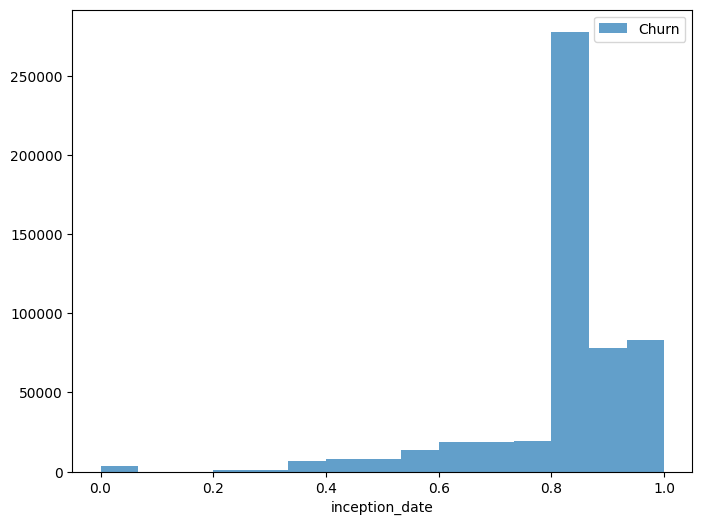

no churn:
count    134895.000000
mean          0.768119
std           0.117686
min           0.120206
5%            0.514993
25%           0.778679
50%           0.806311
75%           0.806311
90%           0.867329
95%           0.904899
99%           0.956154
max           0.998954
Name: inception_date, dtype: float64


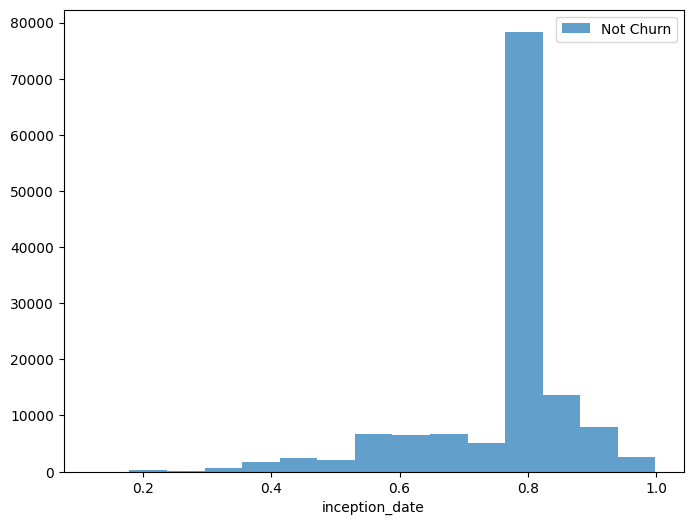

-----------deceased_fair_market_value-----------
churn:
count    538444.00000
mean          0.53809
std          23.29564
min           0.00000
5%            0.00000
25%           0.00000
50%           0.00000
75%           0.00000
90%           0.00000
95%           0.00000
99%           0.00000
max        3493.74000
Name: deceased_fair_market_value, dtype: float64


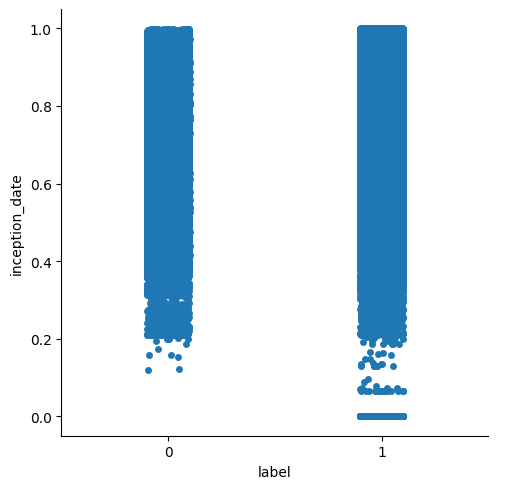

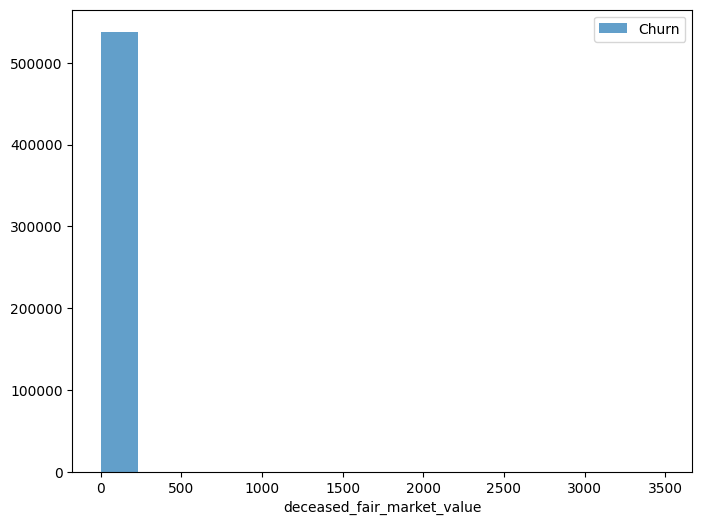

no churn:
count    134895.000000
mean          8.698001
std          92.143642
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%         316.830800
max        3481.280000
Name: deceased_fair_market_value, dtype: float64


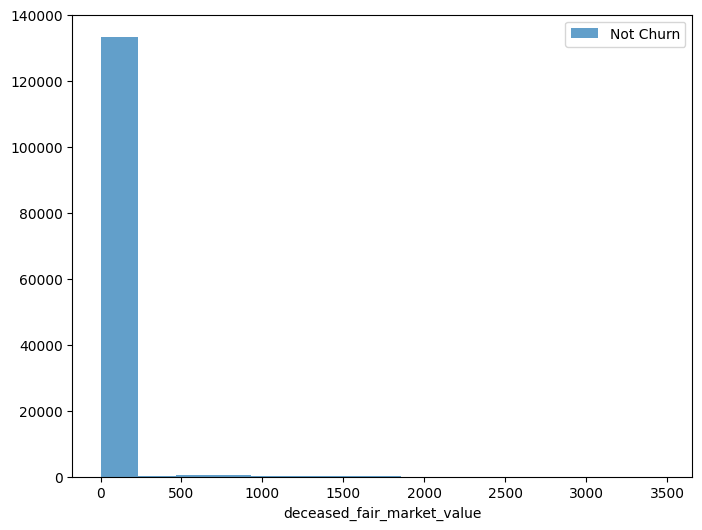

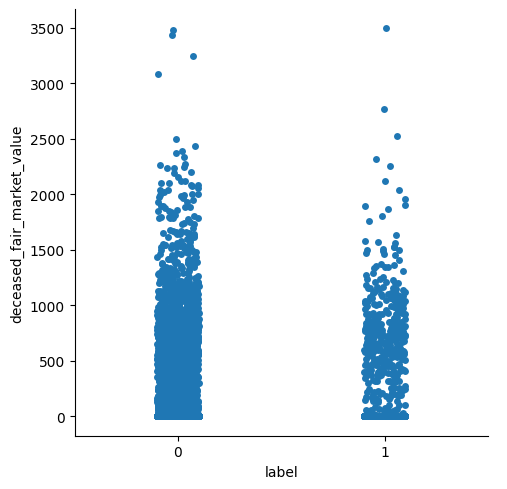

In [ ]:
# Analysis for numeric variables
for col in numeric_variables_a:
    eda_func_num_a(col)

-----------last_update_date-----------
churn:
count    538444.000000
mean          0.644739
std           0.350955
min           0.000000
5%            0.000000
25%           0.466161
50%           0.786140
75%           0.913914
90%           0.963590
95%           0.981050
99%           0.996481
max           1.000000
Name: last_update_date, dtype: float64


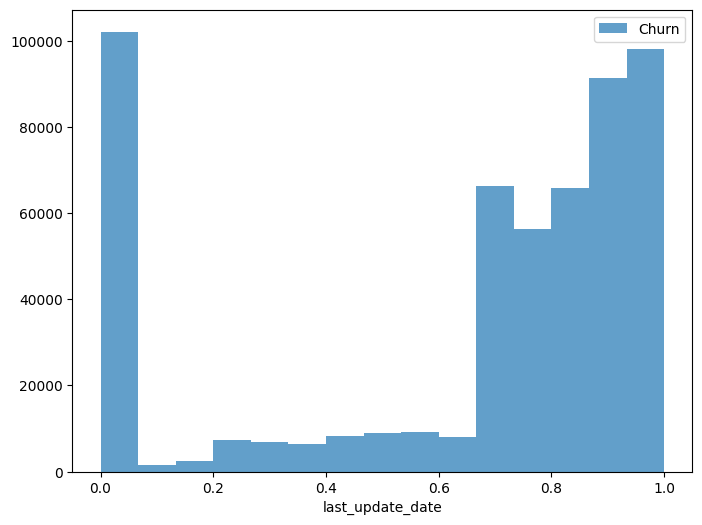

no churn:
count    134895.000000
mean          0.631880
std           0.242575
min           0.000000
5%            0.000000
25%           0.561722
50%           0.699648
75%           0.772604
90%           0.859773
95%           0.912019
99%           0.963048
max           0.999594
Name: last_update_date, dtype: float64


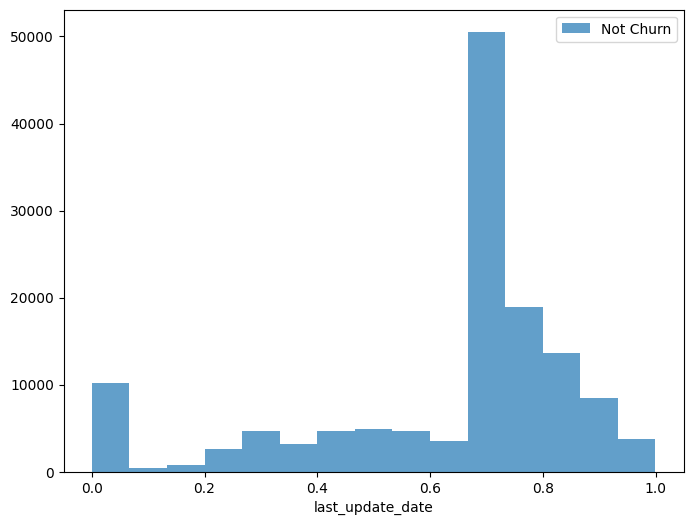

-----------last_maintenance_time-----------
churn:
count    538444.000000
mean          0.809452
std           0.182324
min           0.000000
5%            0.422544
25%           0.726209
50%           0.849091
75%           0.940561
90%           0.977518
95%           0.989529
99%           0.997844
max           1.000000
Name: last_maintenance_time, dtype: float64


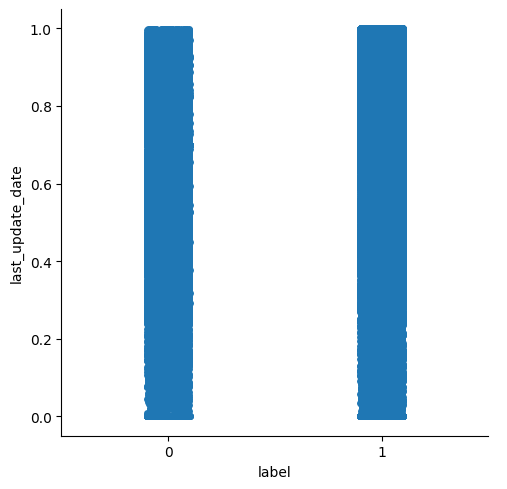

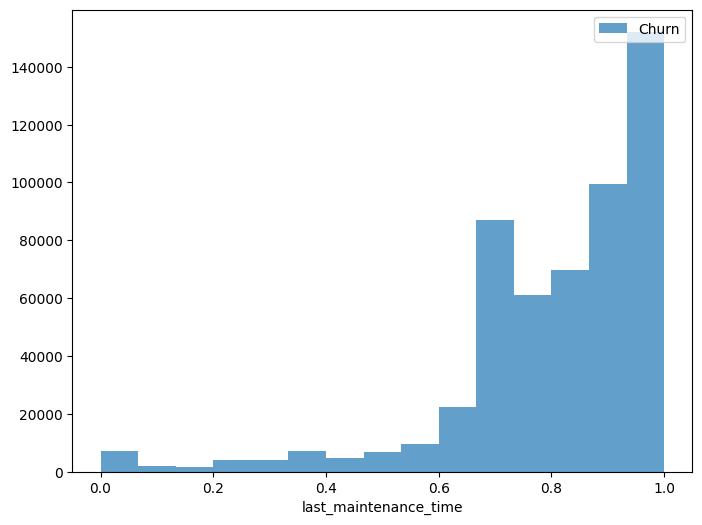

no churn:
count    134895.000000
mean          0.751309
std           0.196081
min           0.003080
5%            0.382507
25%           0.726209
50%           0.737296
75%           0.898676
90%           0.959963
95%           0.981213
99%           0.995996
max           1.000000
Name: last_maintenance_time, dtype: float64


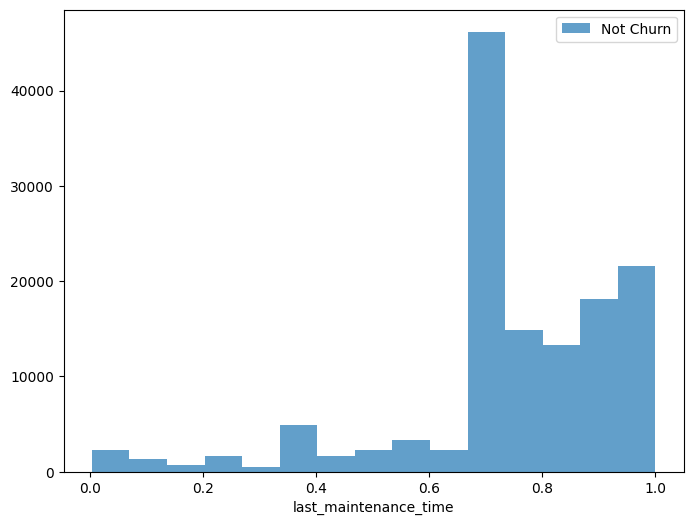

-----------plan_effective_date-----------
churn:
count    538444.000000
mean          0.336512
std           0.409471
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.779847
90%           0.909343
95%           0.952541
99%           0.991677
max           1.000000
Name: plan_effective_date, dtype: float64


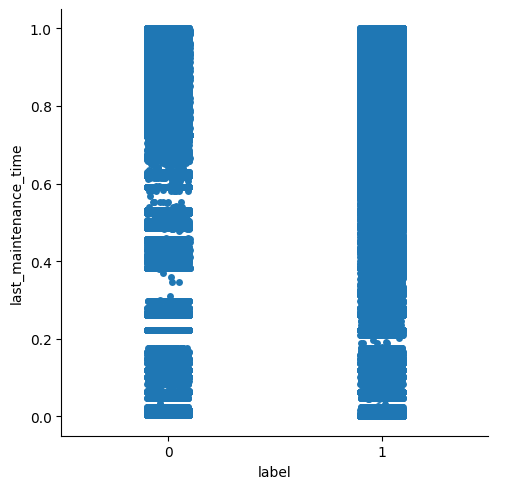

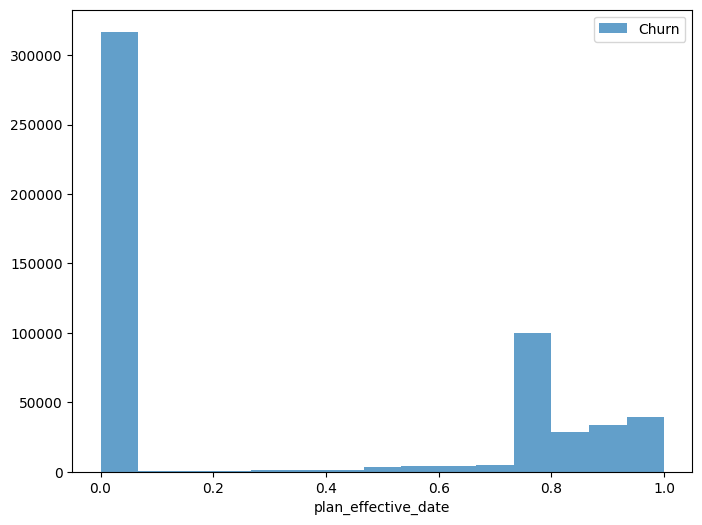

no churn:
count    134895.000000
mean          0.736323
std           0.134098
min           0.000000
5%            0.448727
25%           0.748390
50%           0.779847
75%           0.779847
90%           0.849103
95%           0.891905
99%           0.950163
max           0.998811
Name: plan_effective_date, dtype: float64


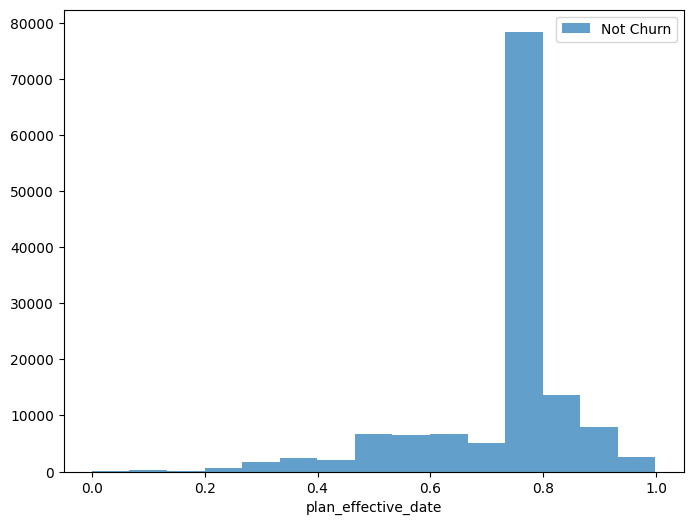

-----------plan_end_date-----------
churn:
count    538444.000000
mean          0.029262
std           0.148246
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%           0.860099
max           1.000000
Name: plan_end_date, dtype: float64


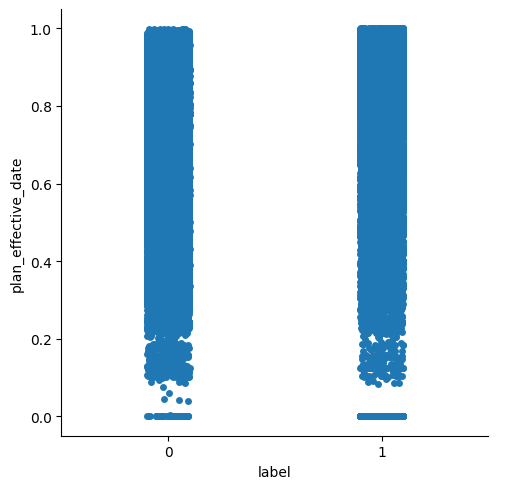

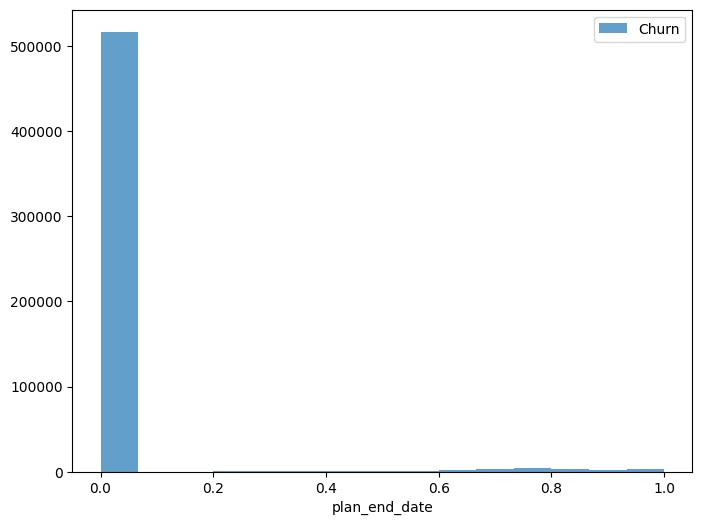

no churn:
count    134895.000000
mean          0.746443
std           0.168776
min           0.000000
5%            0.395033
25%           0.670364
50%           0.748675
75%           0.866722
90%           0.953642
95%           0.978146
99%           0.996854
max           1.000000
Name: plan_end_date, dtype: float64


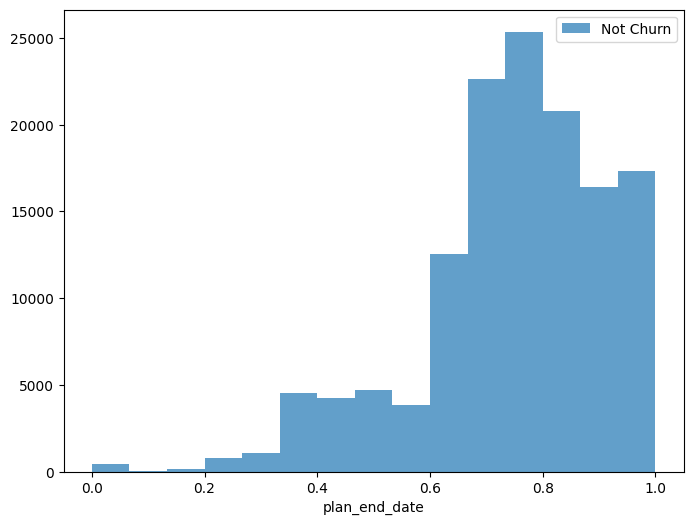

-----------rrif_original_date-----------
churn:
count    538444.000000
mean          0.348901
std           0.423101
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.829024
90%           0.927901
95%           0.961911
99%           0.993229
max           1.000000
Name: rrif_original_date, dtype: float64


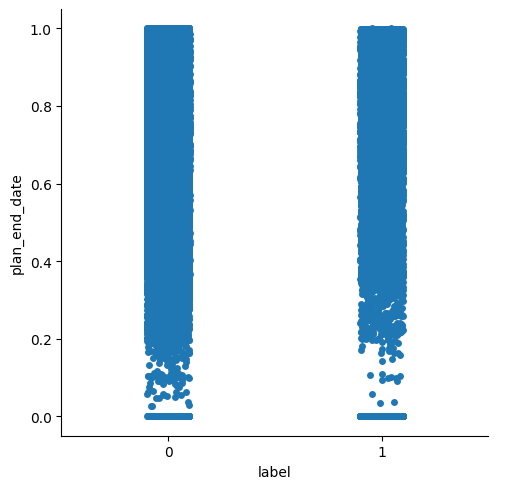

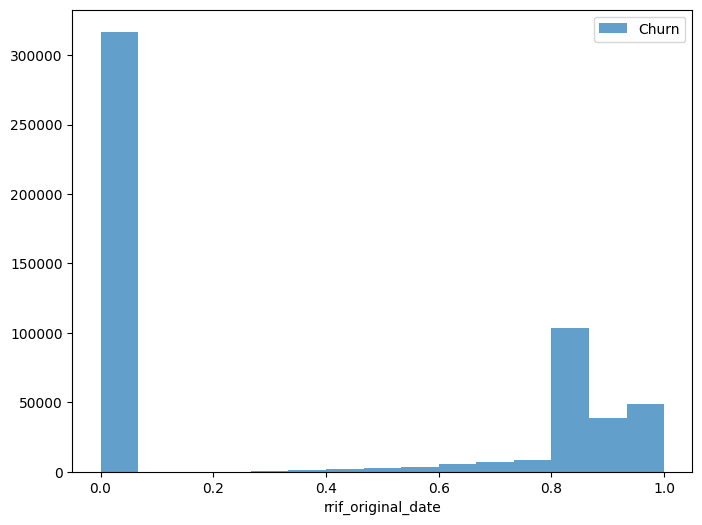

no churn:
count    134895.000000
mean          0.780709
std           0.124340
min           0.000000
5%            0.496999
25%           0.750693
50%           0.829024
75%           0.829024
90%           0.881656
95%           0.915436
99%           0.960680
max           0.999077
Name: rrif_original_date, dtype: float64


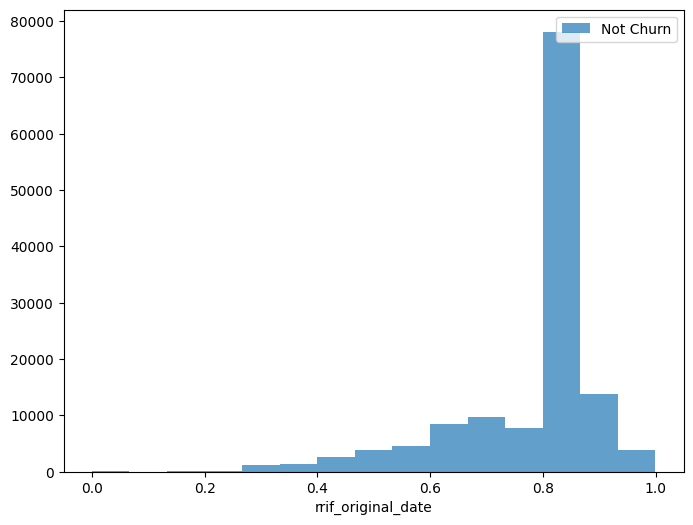

-----------inserted_at-----------
churn:
count    538444.000000
mean          0.009609
std           0.079048
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%           0.497206
max           1.000000
Name: inserted_at, dtype: float64


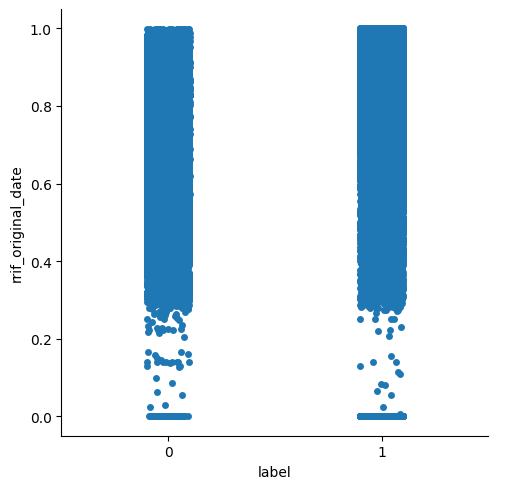

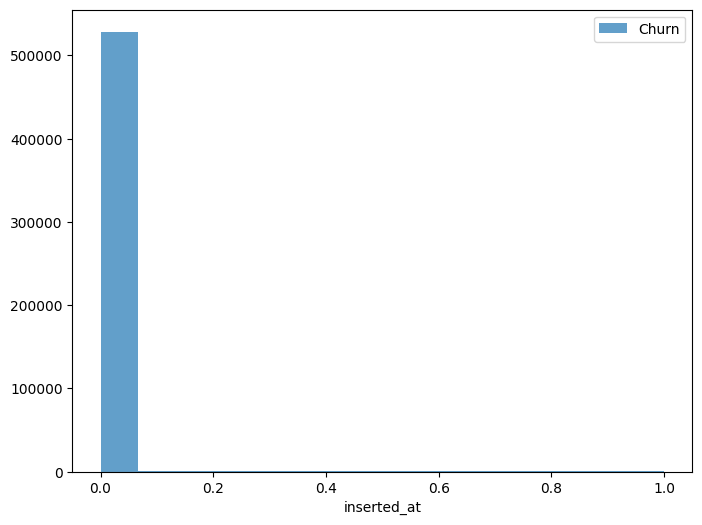

no churn:
count    134895.000000
mean          0.000197
std           0.010164
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%           0.000000
max           0.856408
Name: inserted_at, dtype: float64


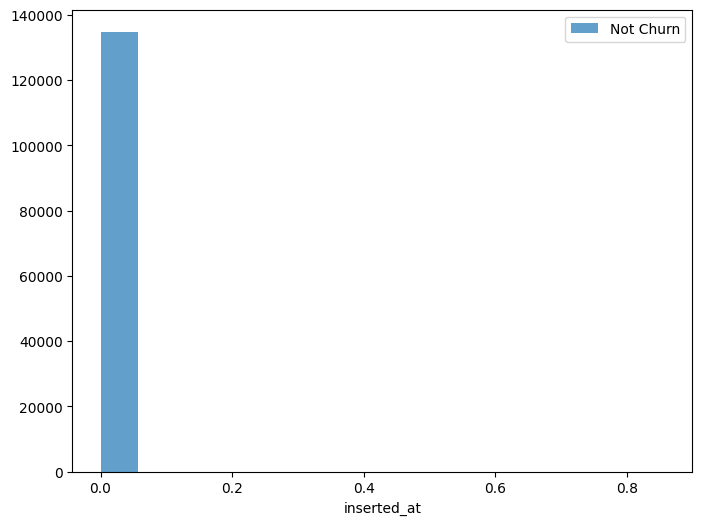

-----------updated_at-----------
churn:
count    538444.000000
mean          0.842085
std           0.066762
min           0.000000
5%            0.835465
25%           0.835465
50%           0.835465
75%           0.860734
90%           0.860734
95%           0.861679
99%           0.912593
max           1.000000
Name: updated_at, dtype: float64


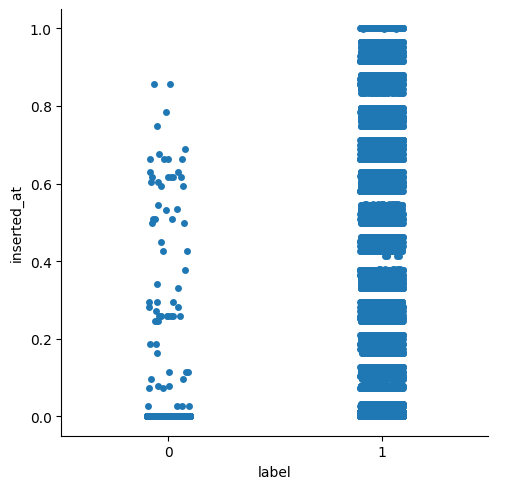

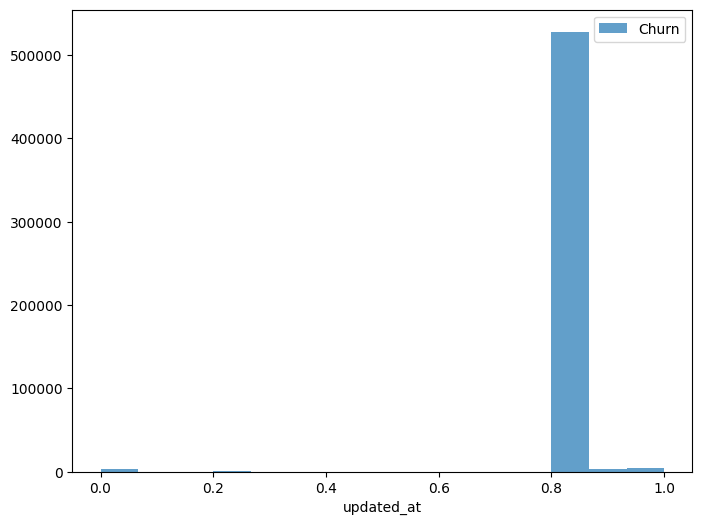

no churn:
count    134895.000000
mean          0.861467
std           0.008333
min           0.835465
5%            0.860734
25%           0.860734
50%           0.860734
75%           0.860734
90%           0.860734
95%           0.861663
99%           0.861746
max           1.000000
Name: updated_at, dtype: float64


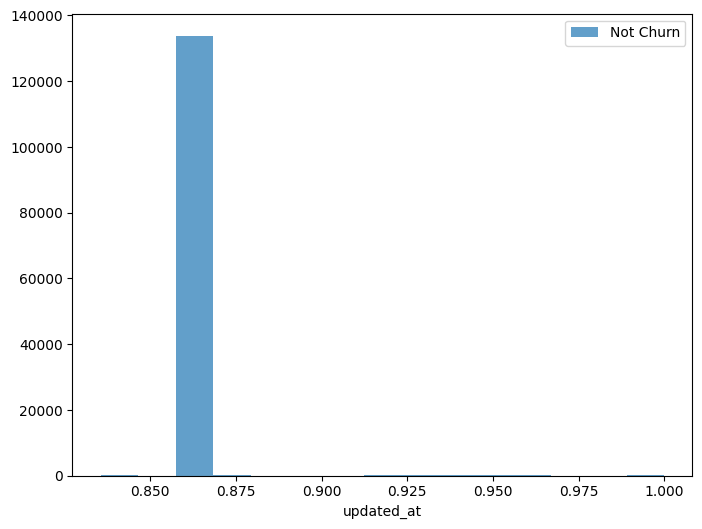

-----------retail_last_maintenance_time-----------
churn:
count    538444.000000
mean          0.370335
std           0.447699
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.905727
90%           0.969101
95%           0.985633
99%           0.997441
max           1.000000
Name: retail_last_maintenance_time, dtype: float64


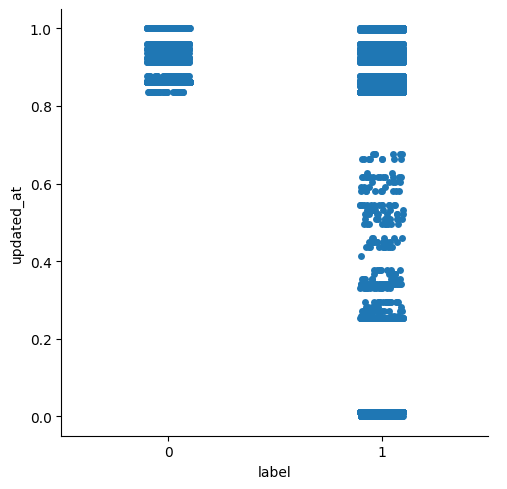

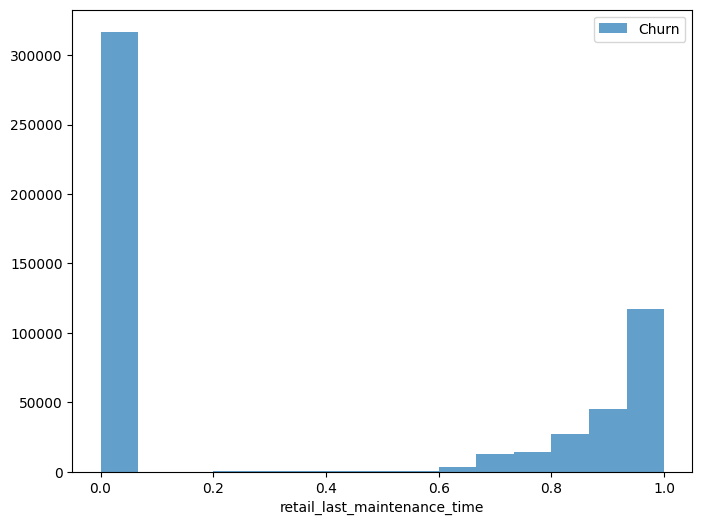

no churn:
count    134895.000000
mean          0.783667
std           0.172420
min           0.000000
5%            0.392639
25%           0.679197
50%           0.825034
75%           0.920685
90%           0.967329
95%           0.986223
99%           0.997441
max           1.000000
Name: retail_last_maintenance_time, dtype: float64


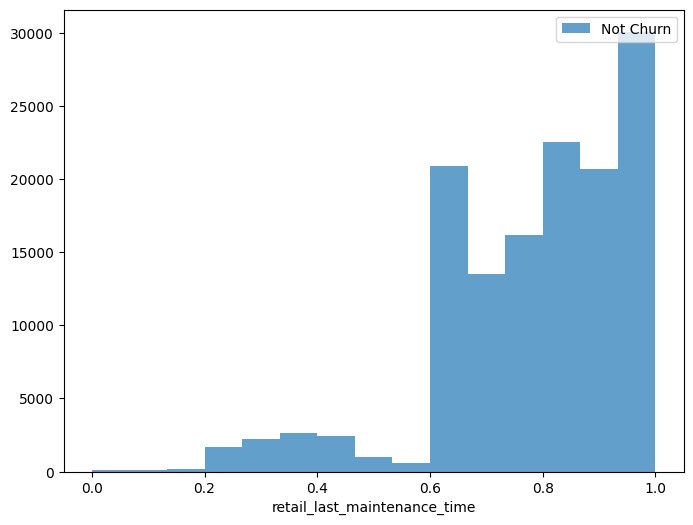

-----------Low-----------
churn:
count    538444.000000
mean          7.575655
std          22.732897
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%          20.000000
95%          75.000000
99%          99.000000
max          99.000000
Name: Low, dtype: float64


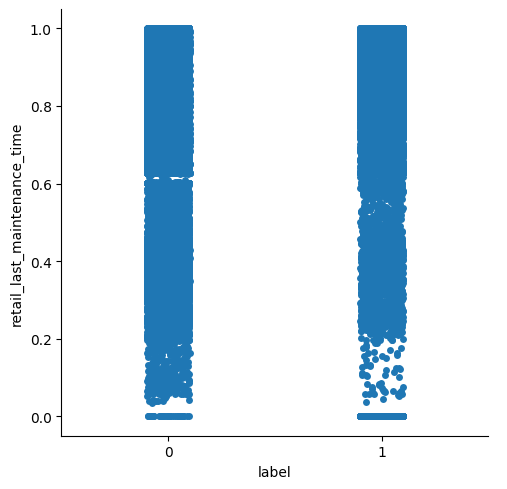

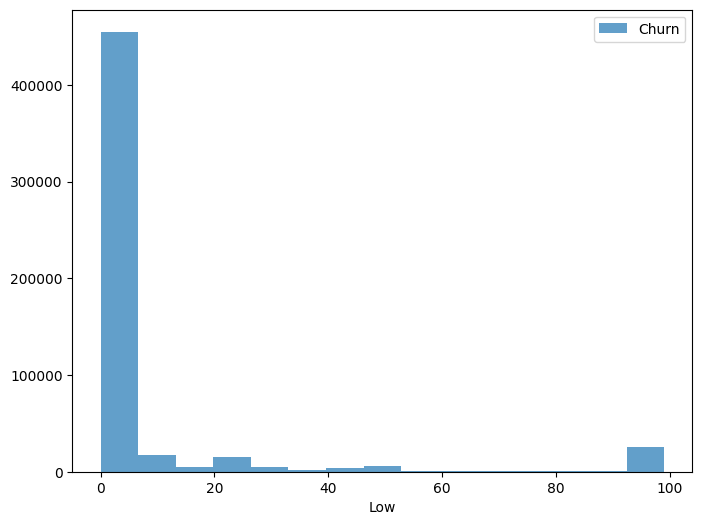

no churn:
count    134895.000000
mean          4.291286
std          14.885867
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%          10.000000
95%          25.000000
99%          99.000000
max          99.000000
Name: Low, dtype: float64


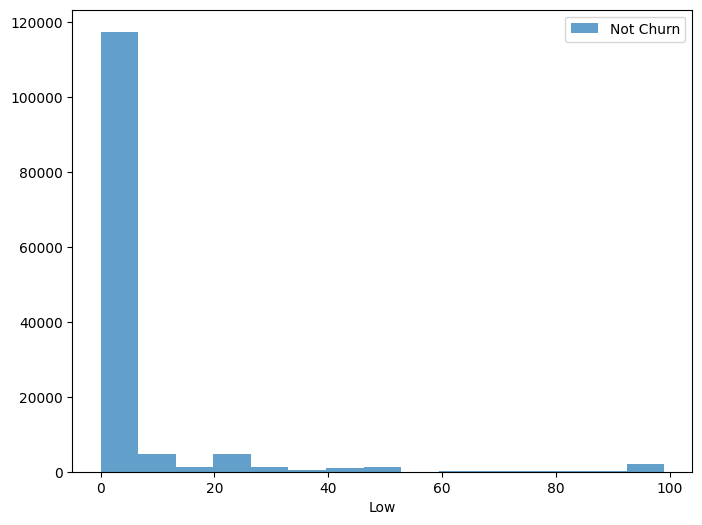

-----------Medium-----------
churn:
count    538444.000000
mean         53.331349
std          41.216564
min           0.000000
5%            0.000000
25%           0.000000
50%          70.000000
75%          90.000000
90%          99.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: Medium, dtype: float64


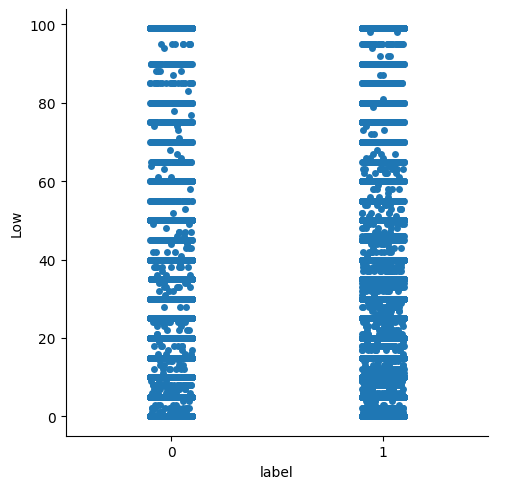

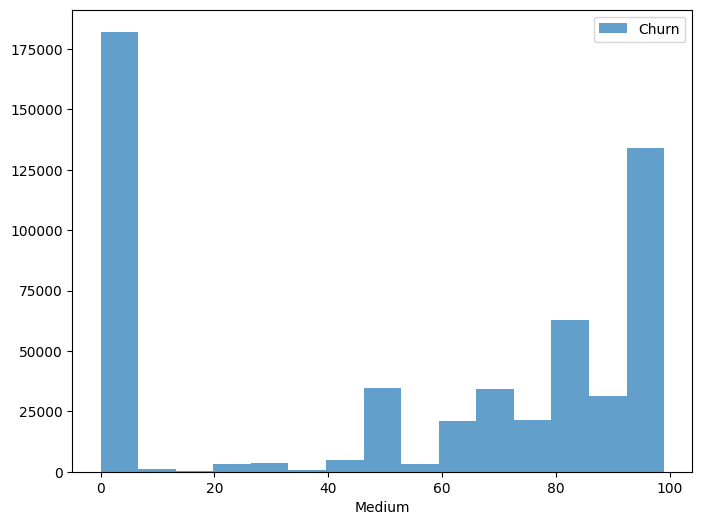

no churn:
count    134895.000000
mean         60.648920
std          38.560118
min           0.000000
5%            0.000000
25%          10.000000
50%          75.000000
75%          99.000000
90%          99.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: Medium, dtype: float64


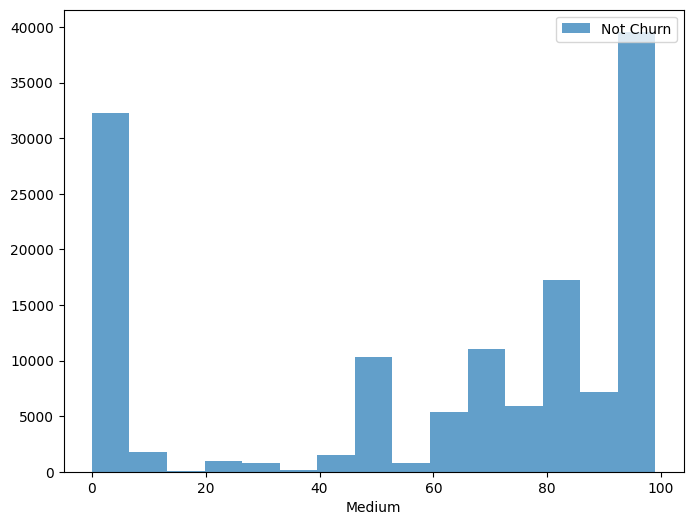

-----------High-----------
churn:
count    538444.000000
mean         15.884203
std          26.480410
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          20.000000
90%          50.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: High, dtype: float64


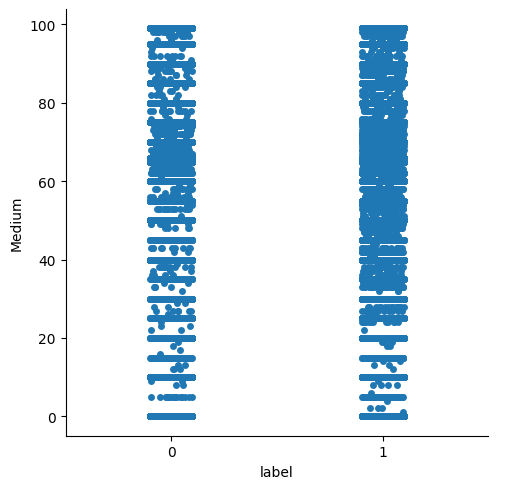

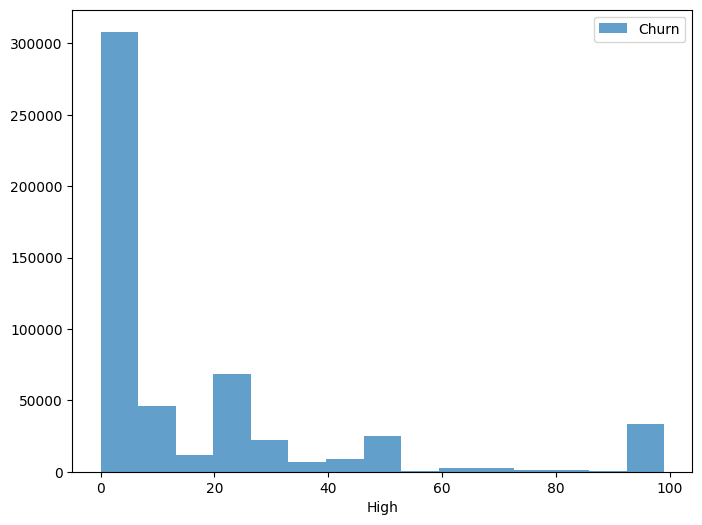

no churn:
count    134895.000000
mean         17.146047
std          25.826878
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          25.000000
90%          50.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: High, dtype: float64


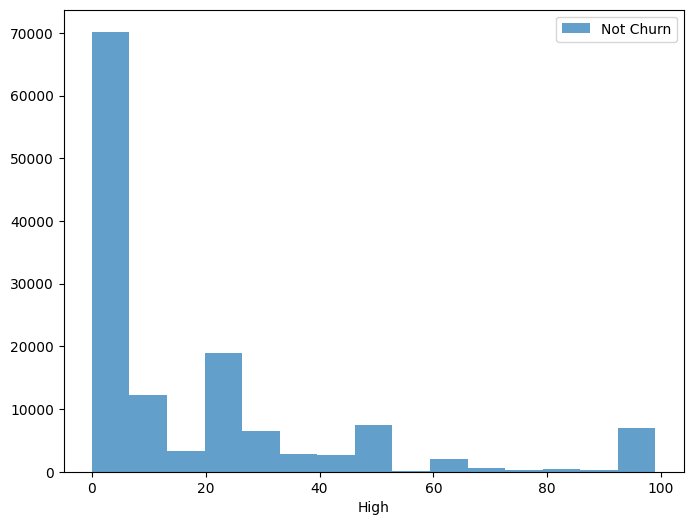

-----------Income-----------
churn:
count    538444.000000
mean          8.933642
std          18.585673
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          10.000000
90%          35.000000
95%          50.000000
99%          99.000000
max          99.000000
Name: Income, dtype: float64


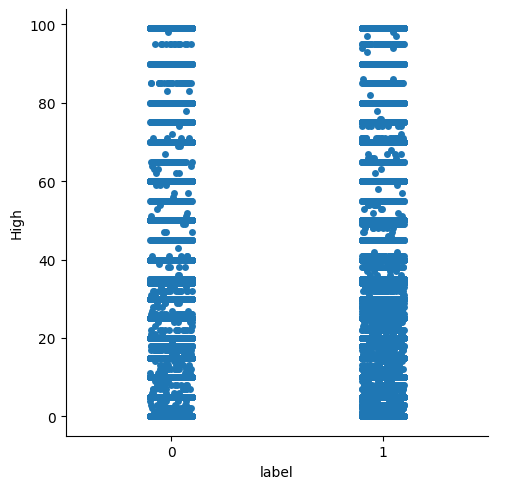

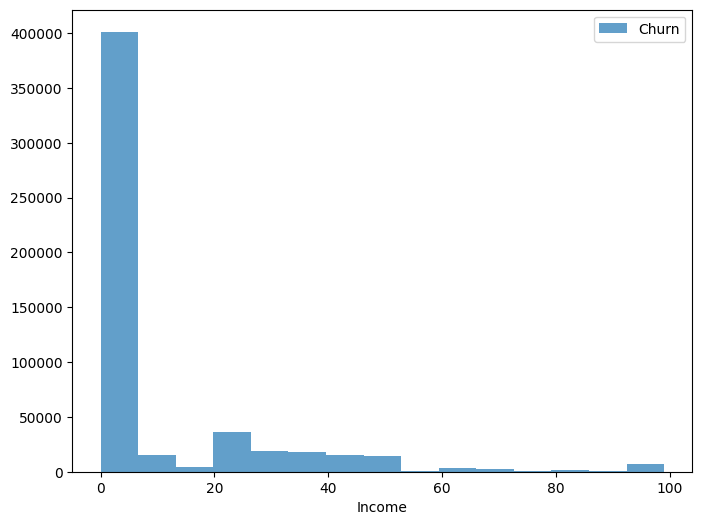

no churn:
count    134895.000000
mean          9.201720
std          18.341799
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          10.000000
90%          33.000000
95%          50.000000
99%          99.000000
max          99.000000
Name: Income, dtype: float64


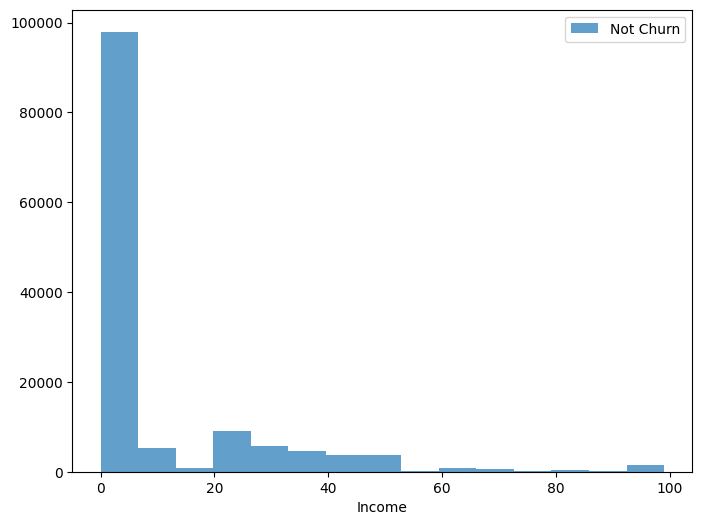

-----------Growth-----------
churn:
count    538444.000000
mean         54.284791
std          41.397975
min           0.000000
5%            0.000000
25%           0.000000
50%          70.000000
75%          99.000000
90%          99.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: Growth, dtype: float64


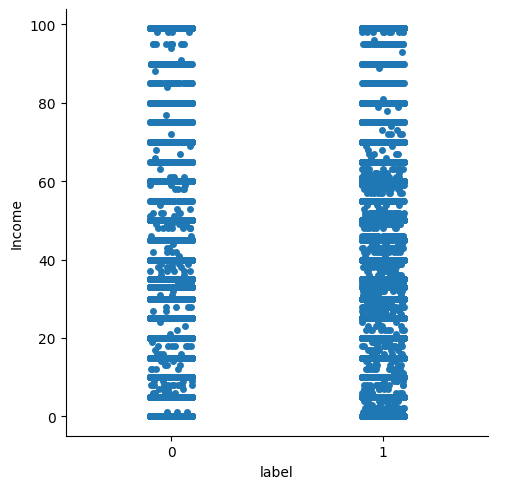

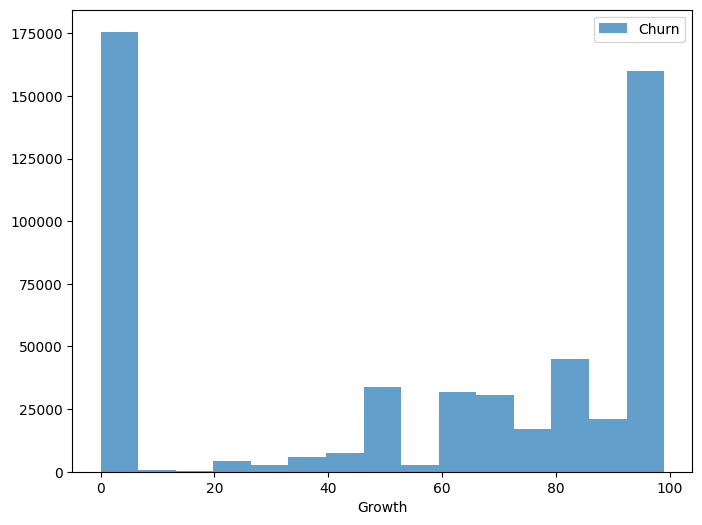

no churn:
count    134895.000000
mean         59.910820
std          38.826025
min           0.000000
5%            0.000000
25%          20.000000
50%          70.000000
75%          99.000000
90%          99.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: Growth, dtype: float64


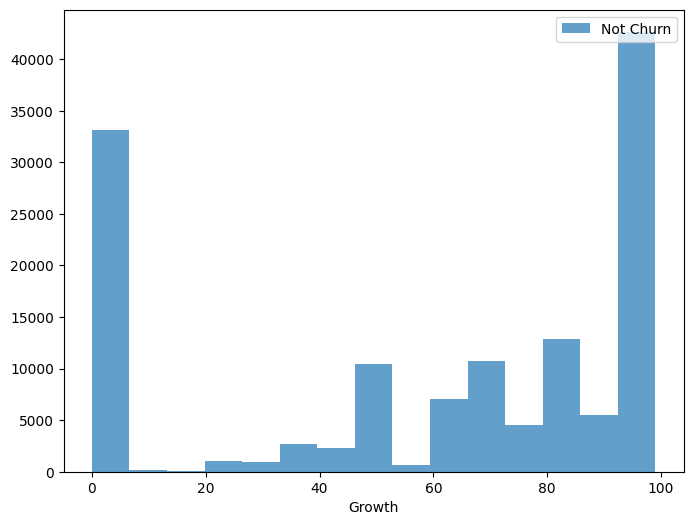

-----------Speculative-----------
churn:
count    538444.000000
mean          9.649767
std          22.953030
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           5.000000
90%          30.000000
95%          50.000000
99%          99.000000
max         100.000000
Name: Speculative, dtype: float64


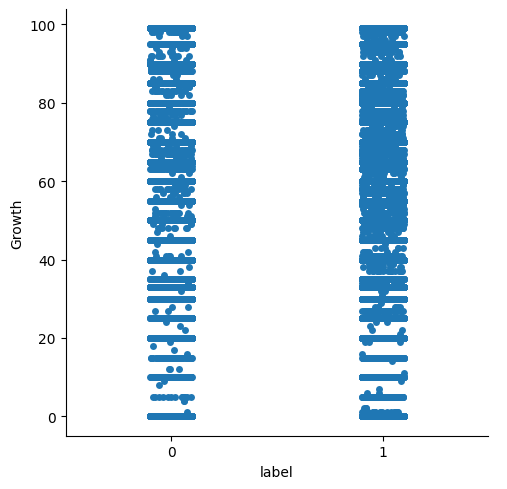

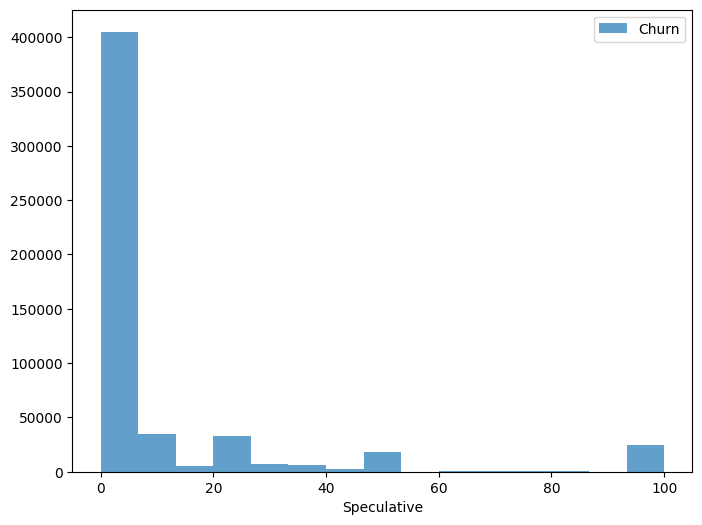

no churn:
count    134895.000000
mean         12.089381
std          23.422675
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          15.000000
90%          50.000000
95%          50.000000
99%          99.000000
max          99.000000
Name: Speculative, dtype: float64


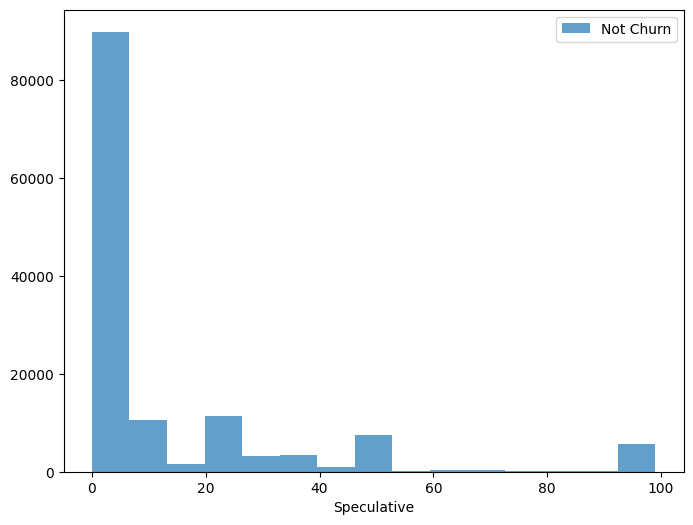

-----------Medium-High-----------
churn:
count    538444.0
mean          0.0
std           0.0
min           0.0
5%            0.0
25%           0.0
50%           0.0
75%           0.0
90%           0.0
95%           0.0
99%           0.0
max           0.0
Name: Medium-High, dtype: float64


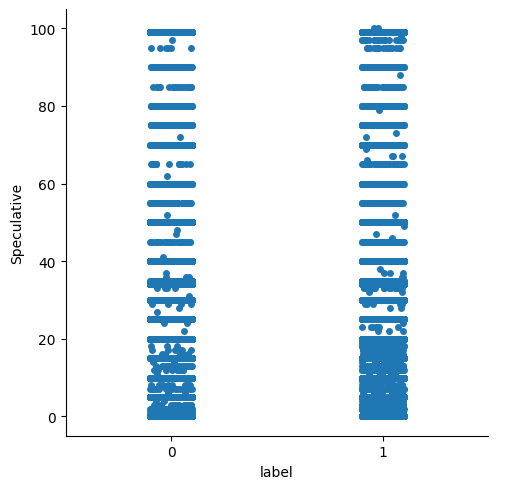

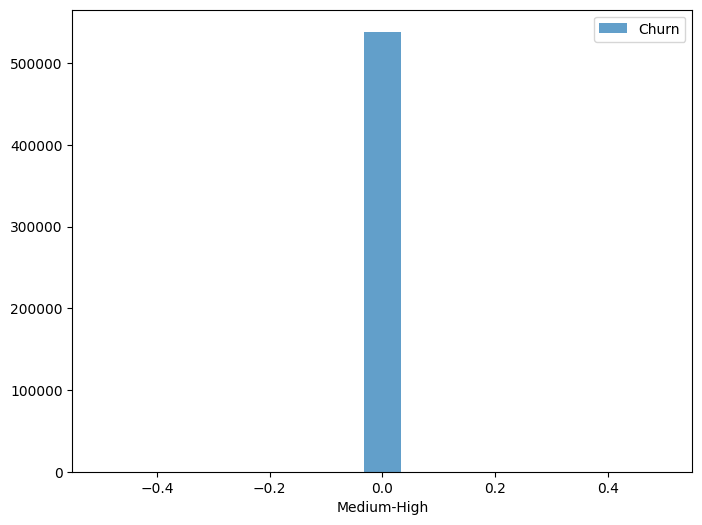

no churn:
count    134895.0
mean          0.0
std           0.0
min           0.0
5%            0.0
25%           0.0
50%           0.0
75%           0.0
90%           0.0
95%           0.0
99%           0.0
max           0.0
Name: Medium-High, dtype: float64


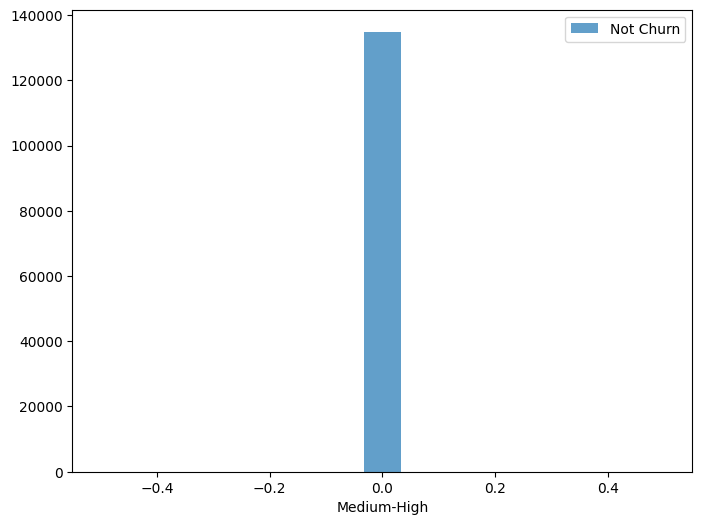

-----------Liquidity-----------
churn:
count    538444.000000
mean          3.910639
std          18.869474
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           5.000000
99%          99.000000
max          99.000000
Name: Liquidity, dtype: float64


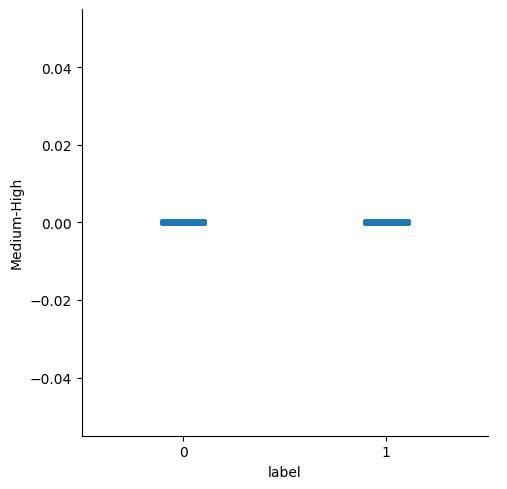

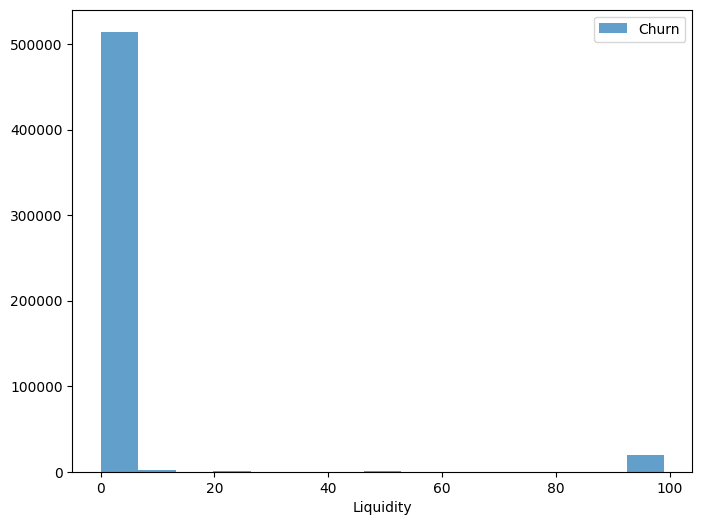

no churn:
count    134895.000000
mean          1.313577
std           8.750313
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%          50.000000
max          99.000000
Name: Liquidity, dtype: float64


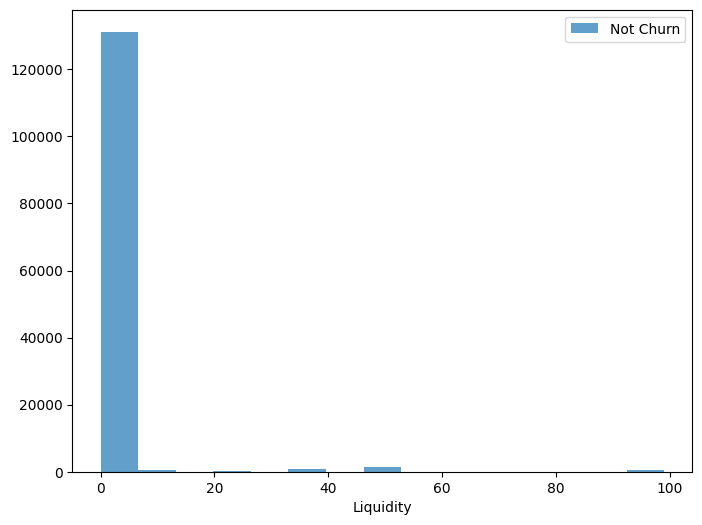

-----------Safety-----------
churn:
count    538444.000000
mean          0.004764
std           0.535307
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%           0.000000
max          99.000000
Name: Safety, dtype: float64


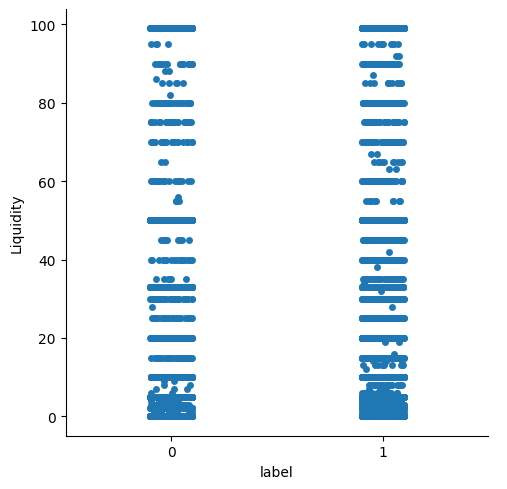

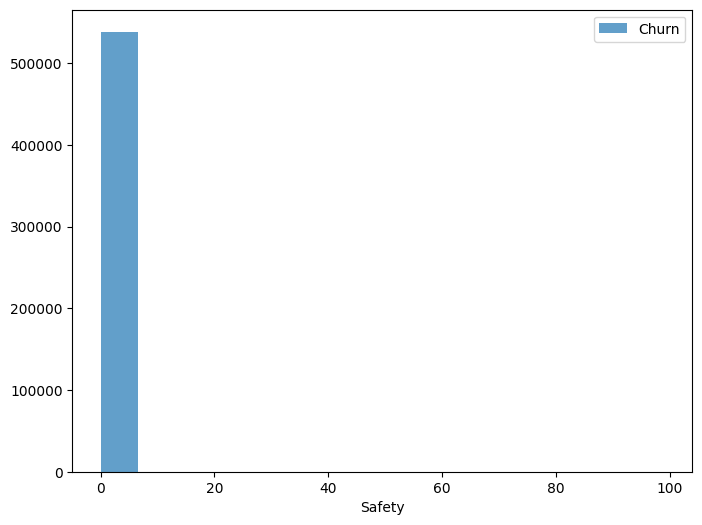

no churn:
count    134895.000000
mean          0.008028
std           0.782272
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%           0.000000
max          99.000000
Name: Safety, dtype: float64


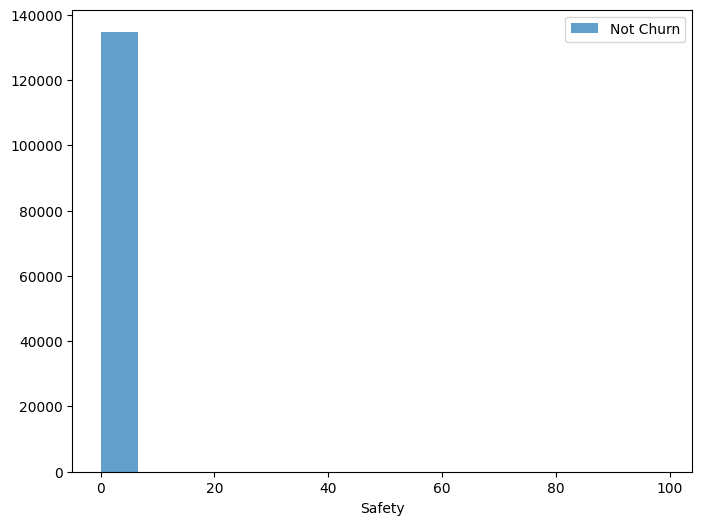

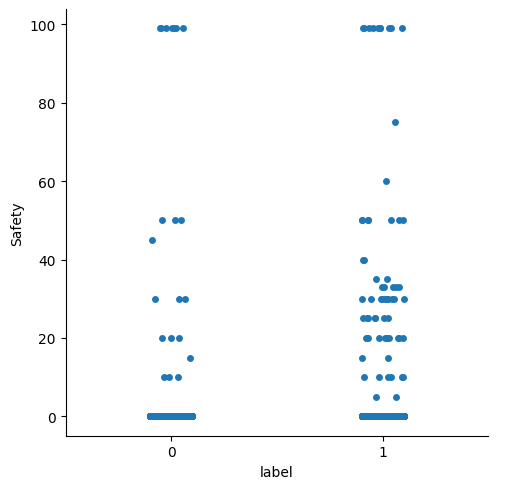

In [ ]:
# Analysis for numeric variables
for col in numeric_variables_ba:
    eda_func_num_ba(col)

### 2.5 Correlation Matrices

<Axes: >

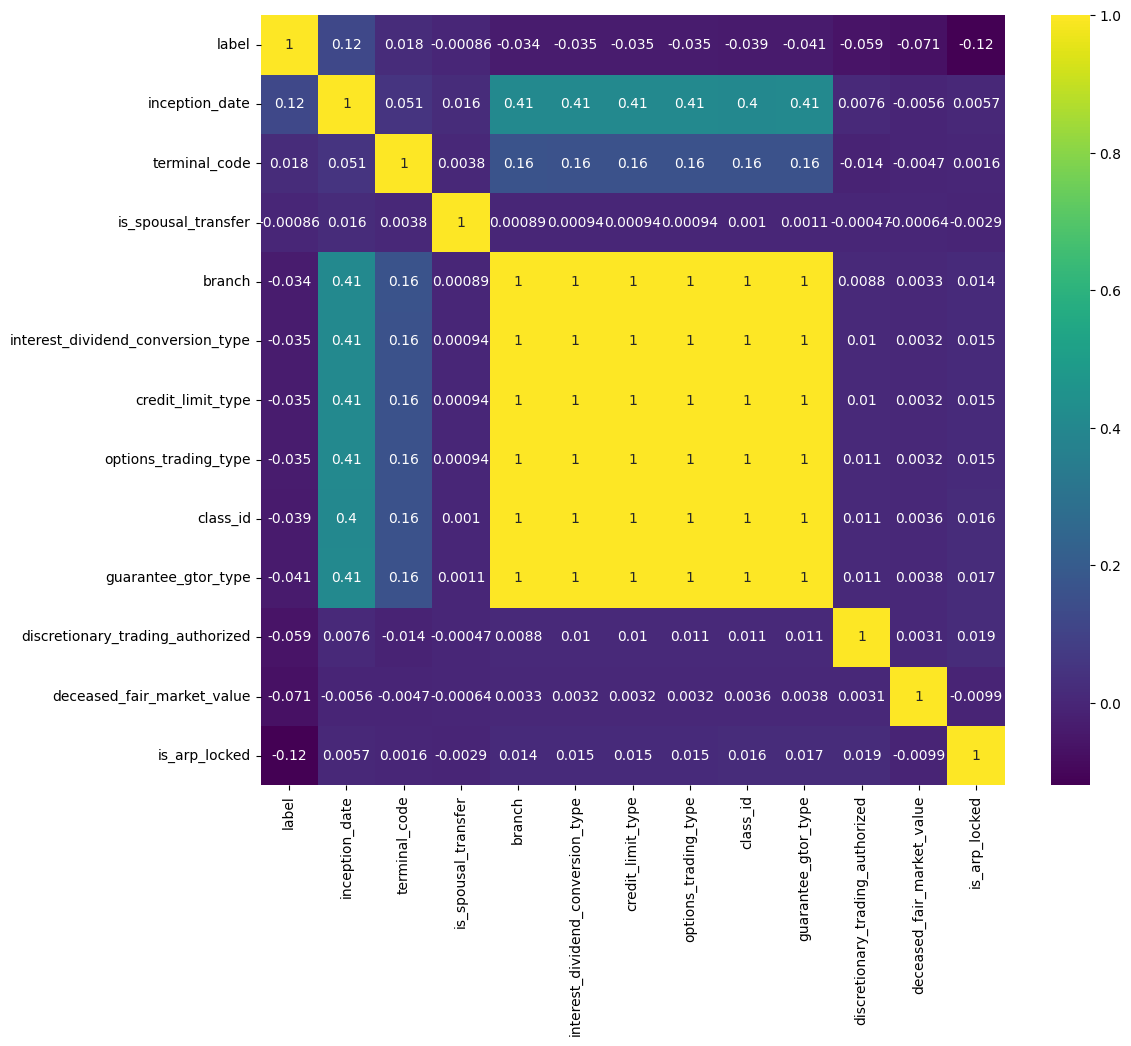

In [ ]:
# Churn correlation matrix (A-AZ)
# Calculate the correlation matrix for columns in a_az_df and select the top 13 columns correlated with 'label'
cols_a = a_az_df.corr().nlargest(13, 'label')['label'].index
cm_a = a_az_df[cols_a].corr()
plt.figure(figsize=(12,10))
sns.heatmap(cm_a, annot=True, cmap = 'viridis')

<ipython-input-116-6aed55396521>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cols = df_eda_first_half.corr().nlargest(23, 'label')['label'].index


<Axes: >

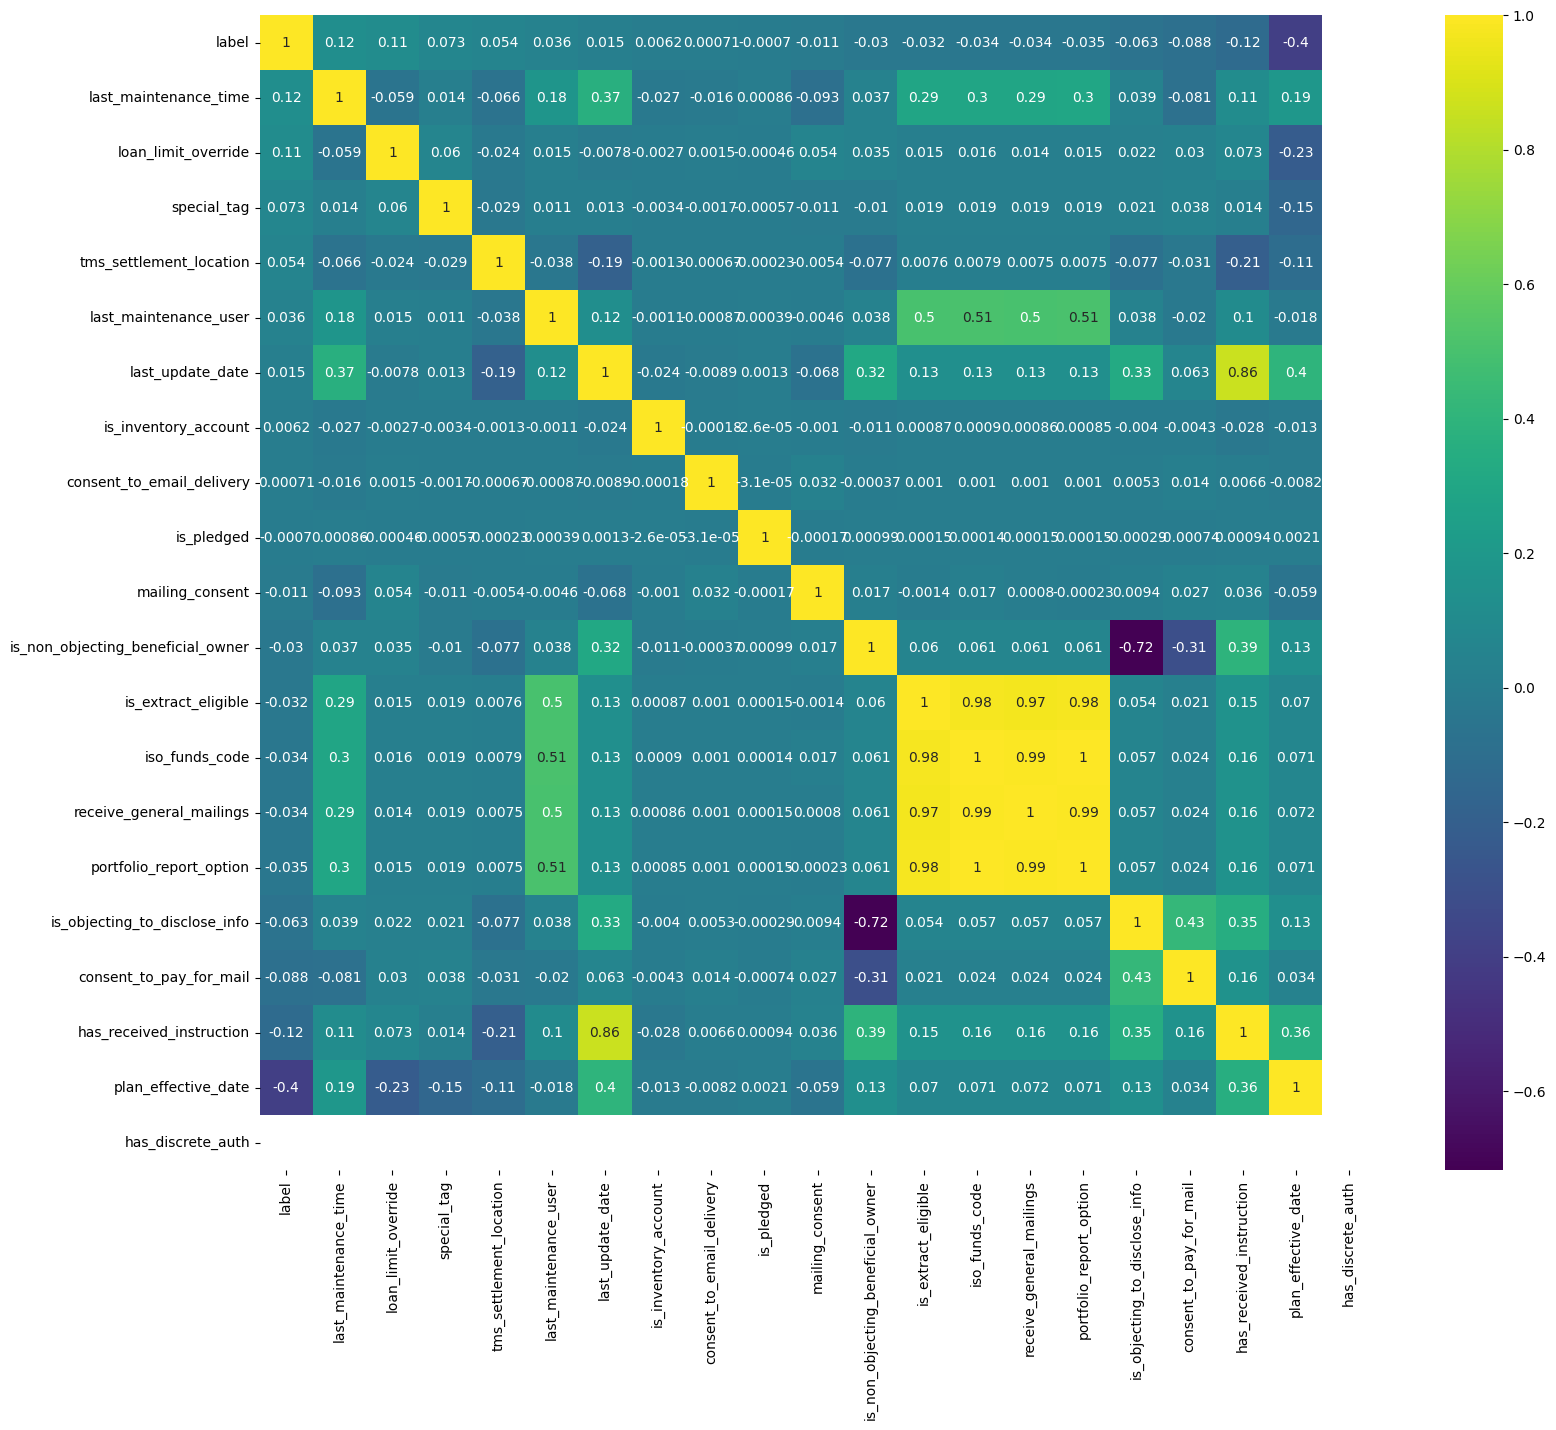

In [ ]:
# Extract the first half of columns from df_eda and add the 'label' column
df_eda_first_half = df_eda.iloc[:, :22]
df_eda_first_half['label'] = df_eda['label']
# Calculate the correlation matrix for columns in df_eda_first_half and select the top 23 columns correlated with 'label'
cols = df_eda_first_half.corr().nlargest(23, 'label')['label'].index
cm = df_eda_first_half[cols].corr()
plt.figure(figsize=(18,15))
sns.heatmap(cm, annot=True, cmap = 'viridis')

<Axes: >

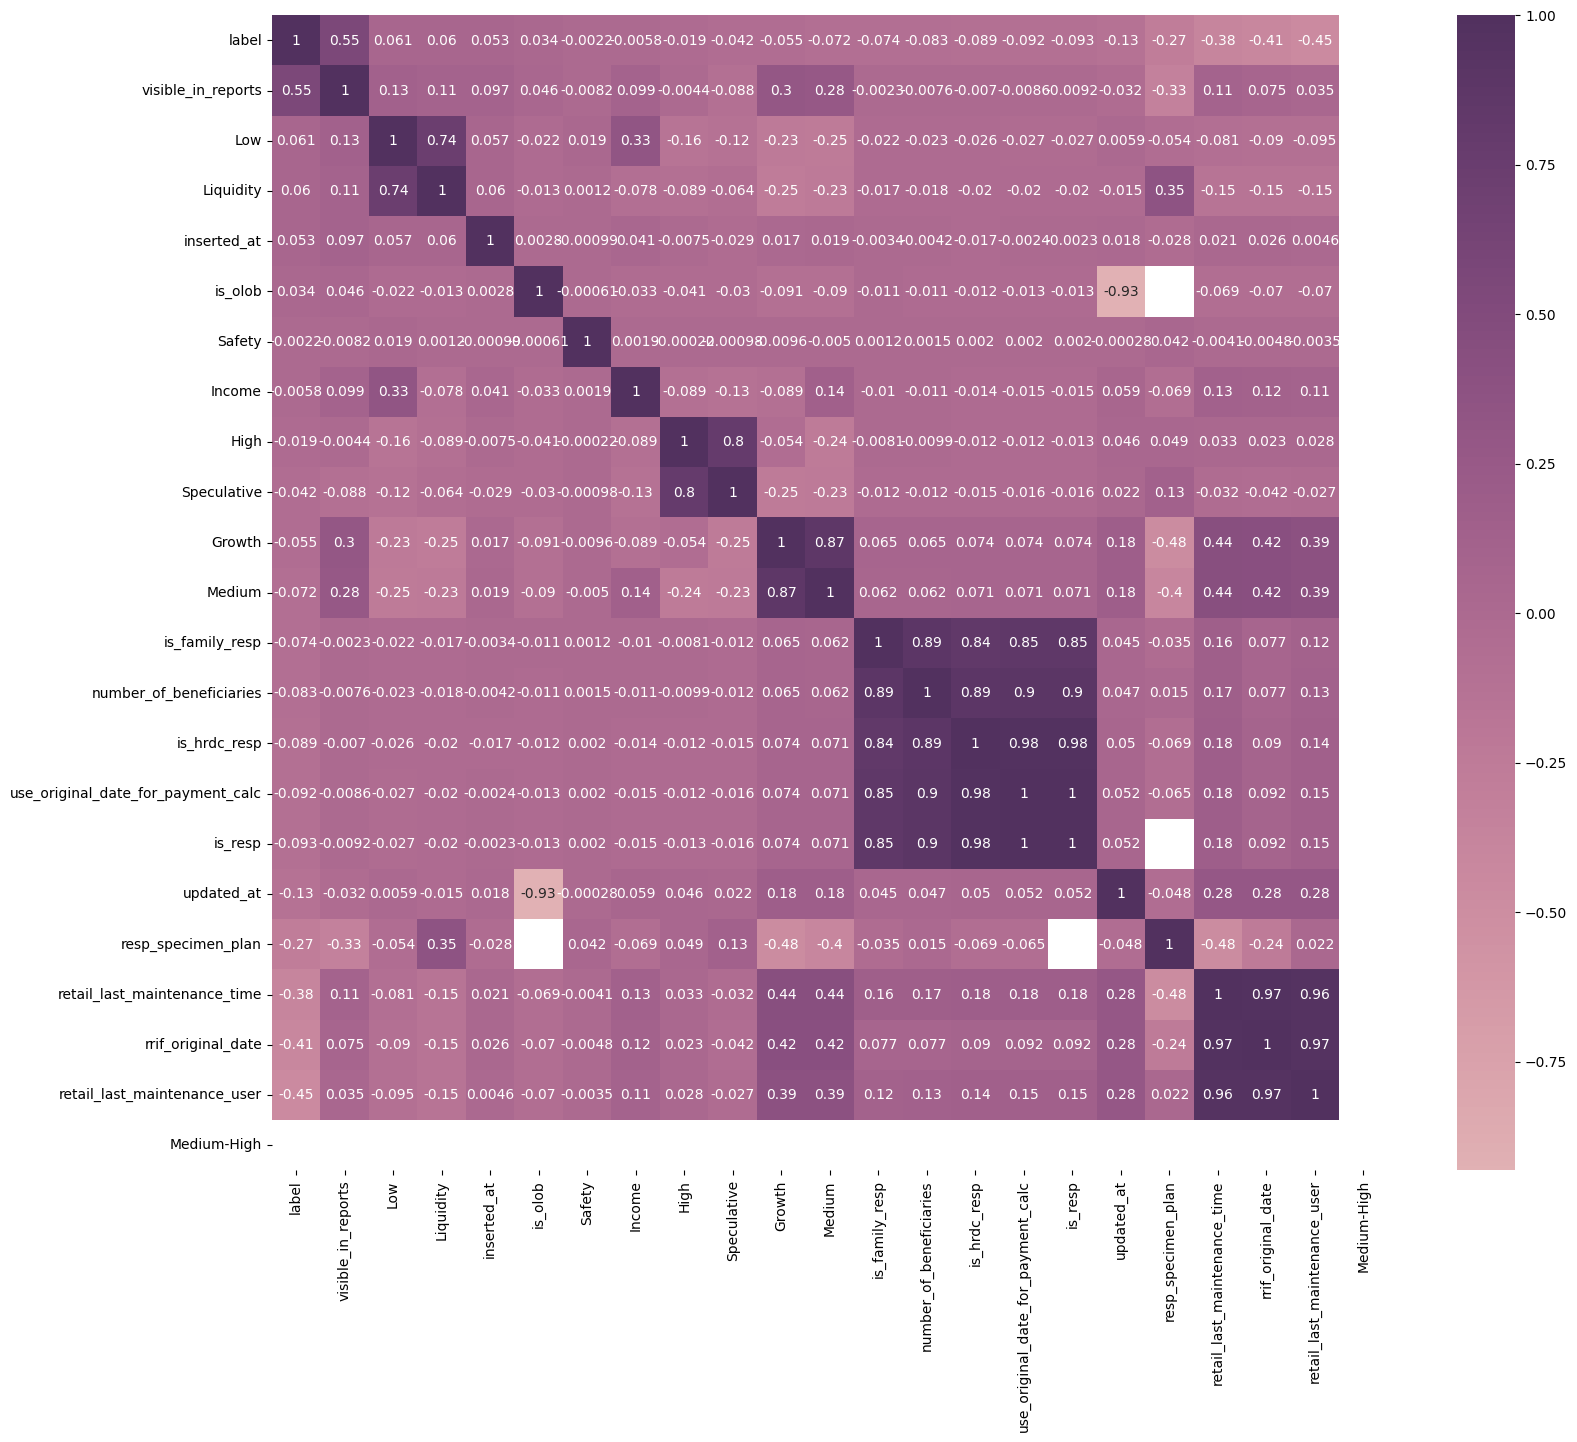

In [ ]:
# Extract the second half of columns from df_eda
df_eda2 = df_eda.iloc[:, 23:]
k = 23
palette = sns.cubehelix_palette(dark=.25, light=.75,as_cmap = True )

# Calculate the correlation matrix for columns in df_eda2 and select the top k columns correlated with 'label'
cols = df_eda2.corr().nlargest(k, 'label')['label'].index
cm = df_eda2[cols].corr()
plt.figure(figsize=(18,15))
sns.heatmap(cm, annot=True, cmap = palette)

In [ ]:
# Collection of all the columns we wish to keep based on EDA for final dataframe
final_df = training_df[['id', 'type_code', 'class_id', 'inception_date', 'credit_limit_type', 'is_arp_locked', 'options_trading_type', 'guarantee_gtor_type', 'deceased_fair_market_value',
                                   'terminal_code', 'iso_funds_code', 'special_tag', 'receive_general_mailings', 'loan_limit_override', 'is_objecting_to_disclose_info', 'consent_to_pay_for_mail',
                                   'has_received_instruction', 'non_calendar_year_end', 'is_resp', 'use_original_date_for_payment_calc', 'is_family_resp', 'is_hrdc_resp', 'resp_specimen_plan',
                                   'visible_in_reports', 'retail_last_maintenance_user', 'rrif_original_date', 'updated_at', 'retail_last_maintenance_time', 'branch', 'last_maintenance_user', 'tms_settlement_location', 'portfolio_report_option', 'label']]
final_df = drop_cols(final_df, [ 'non_calendar_year_end', 'resp_specimen_plan'])
final_df

,id,type_code,class_id,inception_date,credit_limit_type,is_arp_locked,options_trading_type,guarantee_gtor_type,deceased_fair_market_value,terminal_code,...,visible_in_reports,retail_last_maintenance_user,rrif_original_date,updated_at,retail_last_maintenance_time,branch,last_maintenance_user,tms_settlement_location,portfolio_report_option,label
0,893724,1,3.0,0.808752,0.0,0,0.0,0.0,0.0,-999,...,0,-999,0.000000,0.835465,0.000000,5,387,-999,0,1
1,1268094,15,5.0,0.847716,0.0,0,0.0,2.0,0.0,719,...,1,25,0.865574,0.860734,0.954733,5,28,-999,0,1
2,606613,18,5.0,0.542538,0.0,0,0.0,2.0,0.0,755,...,0,174,0.596183,0.860734,0.633734,5,172,-999,0,1
3,741930,0,3.0,0.916405,0.0,0,0.0,0.0,0.0,316,...,1,-999,0.000000,0.835465,0.000000,5,387,-999,0,1
4,1137922,0,3.0,0.806311,0.0,0,0.0,0.0,0.0,719,...,0,-999,0.000000,0.836450,0.000000,5,177,-999,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,6827067,8,5.0,0.995206,0.0,1,0.0,2.0,0.0,719,...,1,25,0.995768,0.861687,0.989372,2,28,-999,0,1
673335,590659,13,5.0,0.466963,0.0,0,0.0,2.0,0.0,719,...,0,25,0.529471,0.860734,0.626845,5,202,-999,0,0
673336,1247774,0,3.0,0.873431,0.0,0,0.0,0.0,0.0,719,...,1,-999,0.000000,0.835465,0.000000,5,28,-999,0,1
673337,1155640,15,5.0,0.806311,0.0,0,0.0,2.0,0.0,124,...,1,374,0.829024,0.860734,0.972643,5,387,-999,0,1


### 3.0 Model Training

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

# Setting up the features and target variables
X = final_df.drop(['id', 'label'], axis = 1)
# Temporary fill of a missing val within the "label" column
y = final_df.label.fillna(0)

# Seed variable to set the random state of the models and enable reproducible results
seed = 123

# Collection of the classification models we wish to evaluate the performance of
models = [('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=seed)),
          ('RF', RandomForestClassifier(random_state=seed)),
          ('GB', GradientBoostingClassifier(random_state=seed)),
          ("LightGBM", LGBMClassifier(random_state=seed)),
          ("XtremeGBRFM", XGBRFClassifier(random_state=seed))]

# Results array to store the cross validation scores
accuracy_results = []
f1_results = []
# Names array to store the name of each model
names = []

# Store max cv score to automatically choose highest cv score model to use
max_cv_score = 0
max_cv_model = ""



In [ ]:
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold

# Assuming 'models' is a list of tuples containing model names and instances
# And 'seed' is defined, along with X, y datasets

max_cv_score = 0  # Initialize max_cv_score
max_cv_model = ''  # Initialize max_cv_model

# Initialize lists for storing results
accuracy_results = []
f1_results = []
names = []

for name, model in models:
    # Setup the KFold cross-validation object
    skfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
    # Get the cross-validation scores for each model
    with parallel_backend('threading', n_jobs=-1):
      cv_results = cross_validate(model, X, y, cv=skfold, scoring=["accuracy", "f1"], return_train_score=False)

    print('done ' + name)
    # Compare and update max f1 score and corresponding model name
    mean_f1_score = np.mean(cv_results['test_f1'])
    if (mean_f1_score > max_cv_score):
        max_cv_score = mean_f1_score
        max_cv_model = name

    # Add the results and names to their respective lists
    accuracy_results.append(cv_results['test_accuracy'])
    f1_results.append(cv_results['test_f1'])
    names.append(name)

    # Print the message with the average and standard deviation of the scores
    msg = "%s: avg accuracy=%f, std of accuracy=%f, avg f1 score=%f" % (
        name,
        cv_results['test_accuracy'].mean(),
        cv_results['test_accuracy'].std(),
        mean_f1_score
    )
    print(msg)

# After the loop, you can print or use max_cv_model and max_cv_score as needed


done KNN
KNN: avg accuracy=0.936420, std of accuracy=0.000889, avg f1 score=0.960121
done CART
CART: avg accuracy=0.952403, std of accuracy=0.000710, avg f1 score=0.970096
done RF
RF: avg accuracy=0.962952, std of accuracy=0.000747, avg f1 score=0.976498
done GB
GB: avg accuracy=0.967741, std of accuracy=0.000721, avg f1 score=0.979416
done LightGBM
LightGBM: avg accuracy=0.968266, std of accuracy=0.000798, avg f1 score=0.979758
done XtremeGBRFM
XtremeGBRFM: avg accuracy=0.967698, std of accuracy=0.000768, avg f1 score=0.979388


### 3.1 Predictions

In [ ]:
# Temporary set model to XGBRFClassifier
chosen_model = XGBRFClassifier(random_state=seed)

for name, model in models:
  if (max_cv_model == name):
    chosen_model = model

chosen_model.fit(X, y)

# drop columns
df_cherry = test_df.iloc[:, 52:79]
df_cherry = drop_cols(df_cherry, ['esir_number', 'dup_trip_quad_code', 'function_code', 'portfolio_cost_method','shareholder_language', 'interactive_portfolio_code', 'title', 'non_plan_book_value_flag', 'conjunction', 'portfolio_name_address_option', 'portfolio_summary_option'])
df_matthew = test_df.iloc[:, -27:]
df_matthew = drop_cols(df_matthew, ['is_broker_account', 'is_gl_account', 'is_control_account', 'is_plan_grandfathered'])
test_df = test_df[['id', 'type_code', 'class_id', 'inception_date', 'branch', 'include_client_consolidation', 'use_client_address', 'credit_limit_type', 'is_arp_locked', 'dividend_confirm_code', 'options_trading_type', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'share_name_address_to_issuer', 'shareholder_instructions_received', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_spousal_transfer', 'terminal_code', 'deceased_fair_market_value', 'discretionary_trading_authorized']]
test_df = pd.concat([test_df, df_cherry, df_matthew], axis=1)
test_df = drop_cols(test_df, ['risk_tolerance', 'investment_objective'])

# map booleans
bool_nathan = ['include_client_consolidation', 'use_client_address', 'is_arp_locked']
bool_cloris = ['share_name_address_to_issuer', 'shareholder_instructions_received', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_spousal_transfer', 'discretionary_trading_authorized']
bool_cherry = ['receive_general_mailings', 'has_discrete_auth', 'is_non_objecting_beneficial_owner', 'is_objecting_to_disclose_info', 'consent_to_email_delivery', 'consent_to_pay_for_mail', 'has_received_instruction']
bool_matthew = ['is_inventory_account', 'is_extract_eligible', 'is_pledged', 'is_resp', 'is_family_resp', 'is_hrdc_resp'] + ['is_olob', 'visible_in_reports', 'use_original_date_for_payment_calc']
test_df = boolean_map(test_df, bool_nathan + bool_cloris + bool_cherry + bool_matthew)

# parse dates
time_nathan = ['inception_date']
time_cherry = ['last_update_date']
time_matthew = ['last_maintenance_time', 'plan_effective_date', 'plan_end_date', 'rrif_original_date', 'inserted_at', 'updated_at', 'retail_last_maintenance_time']
test_df = parse_time(test_df, time_nathan + time_cherry + time_matthew)

# # numerical type
# test_df['special_tag'] = test_df['special_tag'].replace('NOT FOUND', np.nan)


# # Other Stuff
test_df.class_id.fillna(-999, inplace=True)
test_df.credit_limit_type.fillna(-999, inplace=True)
test_df.dividend_confirm_code.fillna(-999, inplace=True)
test_df.deceased_fair_market_value.fillna(0, inplace=True)
test_df.options_trading_type.fillna(-999, inplace=True)
test_df.interest_dividend_conversion_type.fillna(-999, inplace=True)
test_df.guarantee_gtor_type.fillna(-999, inplace=True)
test_df.number_of_beneficiaries.fillna(0, inplace=True)

# Final DF
test_df = test_df[['id', 'type_code', 'class_id', 'inception_date', 'credit_limit_type', 'is_arp_locked', 'options_trading_type', 'guarantee_gtor_type', 'deceased_fair_market_value',
                                   'terminal_code', 'iso_funds_code', 'special_tag', 'receive_general_mailings', 'loan_limit_override', 'is_objecting_to_disclose_info', 'consent_to_pay_for_mail',
                                   'has_received_instruction', 'non_calendar_year_end', 'is_resp', 'use_original_date_for_payment_calc', 'is_family_resp', 'is_hrdc_resp', 'resp_specimen_plan',
                                   'visible_in_reports', 'retail_last_maintenance_user', 'rrif_original_date', 'updated_at', 'retail_last_maintenance_time', 'branch', 'last_maintenance_user', 'tms_settlement_location', 'portfolio_report_option']]
test_df = drop_cols(test_df, [ 'non_calendar_year_end', 'resp_specimen_plan'])

# Manual model choice override
# chosen_model = LGBMClassifier(random_state=seed)
# chosen_model.fit(X, y)

prediction_df = test_df

# make predictions using decided model
results = chosen_model.predict(prediction_df.drop('id', axis=1))

prediction_df['predicted'] = results

### 4.0 Marketing

In [ ]:
marketing_df = pd.DataFrame()
file_path = 'submission.csv'
marketing_df = pd.read_csv(file_path)
marketing_df = marketing_df.drop('Unnamed: 0', axis=1)
churn_df = marketing_df.loc[marketing_df['predicted'] == 1]
no_churn_df = marketing_df.loc[marketing_df['predicted'] == 0]
df_eda = marketing_df

marketing_df

,id,type_code,class_id,inception_date,credit_limit_type,is_arp_locked,options_trading_type,guarantee_gtor_type,deceased_fair_market_value,terminal_code,...,visible_in_reports,retail_last_maintenance_user,rrif_original_date,updated_at,retail_last_maintenance_time,branch,last_maintenance_user,tms_settlement_location,portfolio_report_option,predicted
0,1155742,0,3.0,0.803901,0.0,0,0.0,0.0,0.0,-999,...,1,-999,0.000000,0.835465,0.000000,2,387,-999,0,1
1,1269359,19,5.0,0.888801,0.0,0,0.0,2.0,0.0,38,...,1,336,0.910511,0.860734,0.945787,5,351,-999,0,1
2,573181,0,3.0,0.980319,0.0,0,0.0,0.0,0.0,311,...,1,-999,0.000000,0.835465,0.000000,4,284,-999,0,1
3,967968,19,5.0,0.803901,0.0,0,0.0,2.0,0.0,-999,...,0,374,0.842187,0.860734,0.867579,4,387,-999,0,0
4,595581,0,3.0,0.532521,0.0,0,0.0,0.0,0.0,719,...,1,-999,0.000000,0.836328,0.000000,5,28,-999,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168330,1047726,0,3.0,0.803901,0.0,0,0.0,0.0,0.0,319,...,0,-999,0.000000,0.835465,0.000000,5,433,-999,0,1
168331,888353,1,3.0,0.806372,0.0,0,0.0,0.0,0.0,719,...,0,-999,0.000000,0.836417,0.000000,5,177,-999,0,1
168332,1090674,0,3.0,0.938311,0.0,0,0.0,0.0,0.0,416,...,1,-999,0.000000,0.836298,0.000000,5,73,-999,0,1
168333,1034923,13,5.0,0.803901,0.0,0,0.0,2.0,0.0,719,...,0,25,0.842187,0.860734,0.663526,5,202,-999,0,0


<Axes: >

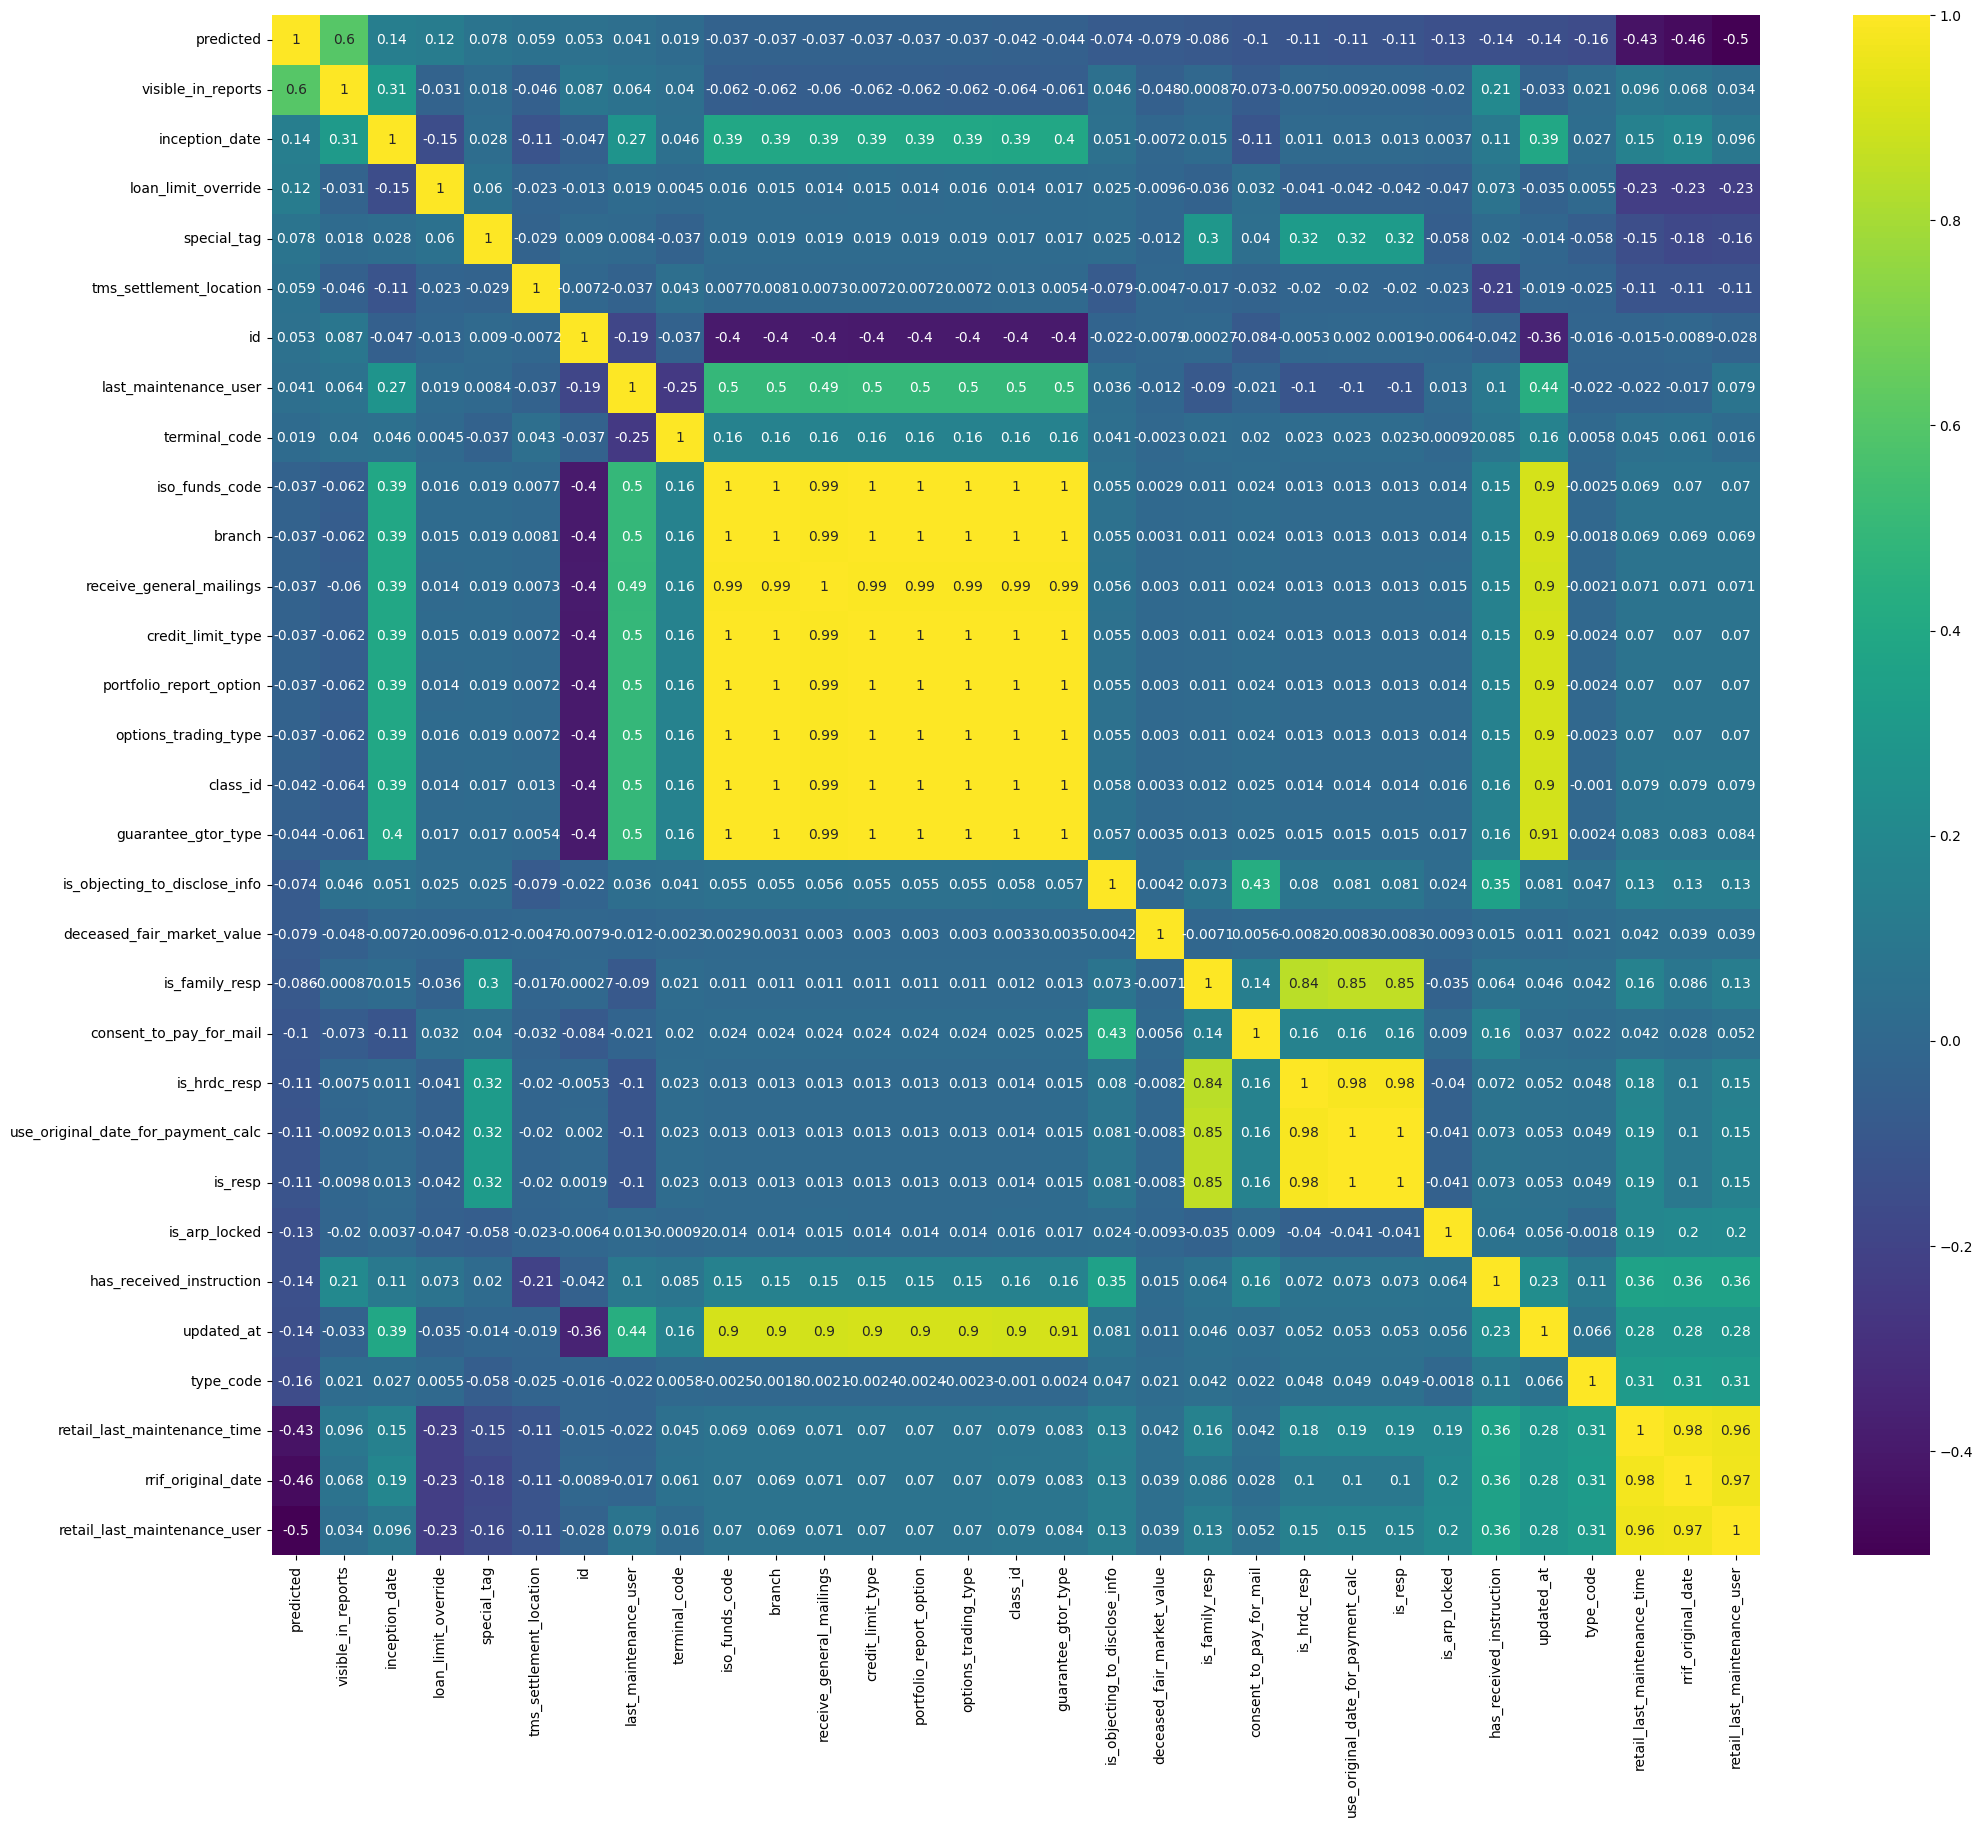

In [ ]:
# Churn correlation matrix
cols = marketing_df.corr().nlargest(31, 'predicted')['predicted'].index
cm = marketing_df[cols].corr()
plt.figure(figsize=(24,20))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [ ]:
# Categorical Variables
categorical_variables = [col for col in marketing_df.columns if marketing_df[col].nunique() <= 50
                        and col not in "label"]

# Numerical Variables
numeric_variables = [col for col in marketing_df.columns if marketing_df[col].dtype != "object"
                        and marketing_df[col].nunique() >50]

categorical_variables.append('last_maintenance_user')
categorical_variables.append('retail_last_maintenance_user')
numeric_variables.remove('last_maintenance_user')
numeric_variables.remove('retail_last_maintenance_user')
numeric_variables.remove('terminal_code')
categorical_variables.append('terminal_code')

print("Categorical Variables: ")
print(categorical_variables)
print("\n")
print("Numeric Variables: ")
print(numeric_variables)

Categorical Variables: 
['type_code', 'class_id', 'credit_limit_type', 'is_arp_locked', 'options_trading_type', 'guarantee_gtor_type', 'iso_funds_code', 'special_tag', 'receive_general_mailings', 'loan_limit_override', 'is_objecting_to_disclose_info', 'consent_to_pay_for_mail', 'has_received_instruction', 'is_resp', 'use_original_date_for_payment_calc', 'is_family_resp', 'is_hrdc_resp', 'visible_in_reports', 'branch', 'tms_settlement_location', 'portfolio_report_option', 'predicted', 'last_maintenance_user', 'retail_last_maintenance_user', 'terminal_code']


Numeric Variables: 
['id', 'inception_date', 'deceased_fair_market_value', 'rrif_original_date', 'updated_at', 'retail_last_maintenance_time']


In [ ]:
# Analysis for categorical variables
for col in categorical_variables:
    eda_func_cat(col)

-----------type_code-----------
Churn:
6: 2 (0.00%)
4: 7 (0.01%)
7: 53 (0.04%)
2: 55 (0.04%)
-999: 76 (0.06%)
5: 117 (0.09%)
12: 219 (0.17%)
16: 424 (0.33%)
9: 766 (0.59%)
17: 1373 (1.06%)
3: 1908 (1.48%)
11: 1910 (1.48%)
18: 2609 (2.02%)
14: 3072 (2.38%)
8: 3571 (2.77%)
15: 5937 (4.60%)
10: 8000 (6.20%)
13: 14542 (11.27%)
19: 16488 (12.77%)
1: 20044 (15.53%)
0: 47903 (37.11%)

No Churn:
1: 1 (0.00%)
6: 1 (0.00%)
2: 1 (0.00%)
10: 1 (0.00%)
16: 2 (0.01%)
0: 2 (0.01%)
12: 57 (0.15%)
7: 59 (0.15%)
17: 821 (2.09%)
11: 1119 (2.85%)
14: 2825 (7.20%)
18: 2918 (7.43%)
8: 3563 (9.08%)
15: 3715 (9.46%)
19: 10238 (26.08%)
13: 13936 (35.50%)
-----------class_id-----------
Churn:
50.0: 1 (0.00%)
15.0: 1 (0.00%)
38.0: 1 (0.00%)
23.0: 1 (0.00%)
17.0: 1 (0.00%)
16.0: 1 (0.00%)
41.0: 1 (0.00%)
58.0: 1 (0.00%)
39.0: 1 (0.00%)
70.0: 1 (0.00%)
53.0: 1 (0.00%)
40.0: 1 (0.00%)
52.0: 2 (0.00%)
47.0: 2 (0.00%)
19.0: 2 (0.00%)
26.0: 2 (0.00%)
34.0: 2 (0.00%)
74.0: 3 (0.00%)
48.0: 3 (0.00%)
61.0: 3 (0.00%)
18.0

<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is depreca

0: 39257 (99.99%)
-----------branch-----------
Churn:
7: 21 (0.02%)
3: 76 (0.06%)
1: 143 (0.11%)
8: 618 (0.48%)
-999: 766 (0.59%)
0: 813 (0.63%)
2: 12839 (9.95%)
4: 19229 (14.90%)
5: 94571 (73.27%)

No Churn:
3: 9 (0.02%)
1: 114 (0.29%)
8: 366 (0.93%)
0: 1216 (3.10%)
2: 3439 (8.76%)
4: 4640 (11.82%)
5: 29475 (75.08%)
-----------tms_settlement_location-----------
Churn:
6: 1 (0.00%)
10: 1 (0.00%)
11: 2 (0.00%)
2: 2 (0.00%)
13: 3 (0.00%)
5: 42 (0.03%)
0: 42 (0.03%)
4: 43 (0.03%)
7: 84 (0.07%)
1: 543 (0.42%)
12: 1145 (0.89%)
-999: 127168 (98.52%)

No Churn:
-999: 39259 (100.00%)
-----------portfolio_report_option-----------
Churn:
1: 2 (0.00%)
-999: 767 (0.59%)
0: 128307 (99.40%)

No Churn:
2: 2 (0.01%)
0: 39257 (99.99%)
-----------predicted-----------
Churn:
1: 129076 (100.00%)

No Churn:
0: 39259 (100.00%)
-----------last_maintenance_user-----------
Churn:
361: 1 (0.00%)
99: 1 (0.00%)
248: 1 (0.00%)
41: 1 (0.00%)
262: 1 (0.00%)
124: 1 (0.00%)
220: 1 (0.00%)
292: 1 (0.00%)
404: 1 (0.00%)

<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is depreca

286: 2 (0.00%)
163: 2 (0.00%)
410: 2 (0.00%)
13: 2 (0.00%)
160: 3 (0.00%)
430: 3 (0.00%)
187: 3 (0.00%)
209: 3 (0.00%)
375: 3 (0.00%)
75: 3 (0.00%)
79: 4 (0.00%)
406: 4 (0.00%)
390: 4 (0.00%)
1: 4 (0.00%)
417: 4 (0.00%)
12: 5 (0.00%)
122: 5 (0.00%)
323: 5 (0.00%)
212: 6 (0.00%)
302: 8 (0.01%)
412: 8 (0.01%)
101: 8 (0.01%)
384: 9 (0.01%)
41: 11 (0.01%)
8: 11 (0.01%)
43: 11 (0.01%)
144: 11 (0.01%)
370: 12 (0.01%)
219: 14 (0.01%)
407: 15 (0.01%)
179: 17 (0.01%)
315: 17 (0.01%)
289: 17 (0.01%)
356: 18 (0.01%)
158: 18 (0.01%)
127: 18 (0.01%)
115: 18 (0.01%)
198: 19 (0.01%)
218: 19 (0.01%)
84: 20 (0.02%)
159: 20 (0.02%)
21: 20 (0.02%)
11: 20 (0.02%)
354: 21 (0.02%)
330: 24 (0.02%)
196: 24 (0.02%)
400: 25 (0.02%)
68: 26 (0.02%)
16: 28 (0.02%)
284: 29 (0.02%)
206: 34 (0.03%)
257: 34 (0.03%)
351: 42 (0.03%)
268: 43 (0.03%)
238: 45 (0.03%)
185: 48 (0.04%)
414: 48 (0.04%)
329: 52 (0.04%)
348: 53 (0.04%)
340: 53 (0.04%)
70: 67 (0.05%)
151: 68 (0.05%)
397: 81 (0.06%)
199: 84 (0.07%)
249: 93 (0.07%)

<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():
<ipython-input-107-4facf1ff307e>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in churn_counts.iteritems():


415: 145 (0.37%)
166: 146 (0.37%)
319: 147 (0.37%)
93: 147 (0.37%)
153: 154 (0.39%)
197: 155 (0.39%)
331: 157 (0.40%)
22: 177 (0.45%)
231: 193 (0.49%)
326: 195 (0.50%)
422: 199 (0.51%)
403: 202 (0.51%)
405: 205 (0.52%)
276: 209 (0.53%)
352: 210 (0.53%)
222: 214 (0.55%)
90: 219 (0.56%)
274: 219 (0.56%)
264: 233 (0.59%)
29: 256 (0.65%)
329: 285 (0.73%)
377: 292 (0.74%)
407: 346 (0.88%)
349: 353 (0.90%)
335: 468 (1.19%)
265: 476 (1.21%)
164: 772 (1.97%)
83: 1071 (2.73%)
373: 1462 (3.72%)
163: 1600 (4.08%)
151: 1657 (4.22%)
179: 2655 (6.76%)
374: 7156 (18.23%)
25: 12220 (31.13%)
-----------terminal_code-----------
Churn:
682: 1 (0.00%)
1394: 1 (0.00%)
1384: 1 (0.00%)
656: 1 (0.00%)
684: 1 (0.00%)
705: 1 (0.00%)
659: 1 (0.00%)
637: 1 (0.00%)
1377: 1 (0.00%)
1411: 1 (0.00%)
1392: 1 (0.00%)
691: 1 (0.00%)
690: 1 (0.00%)
703: 1 (0.00%)
636: 1 (0.00%)
686: 1 (0.00%)
679: 1 (0.00%)
1397: 1 (0.00%)
1416: 1 (0.00%)
616: 1 (0.00%)
699: 1 (0.00%)
1402: 1 (0.00%)
1361: 1 (0.00%)
1429: 1 (0.00%)
680: 

<ipython-input-107-4facf1ff307e>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in no_churn_counts.iteritems():


518: 3 (0.01%)
1327: 3 (0.01%)
1333: 3 (0.01%)
311: 3 (0.01%)
519: 3 (0.01%)
485: 3 (0.01%)
1257: 3 (0.01%)
559: 3 (0.01%)
1153: 3 (0.01%)
584: 3 (0.01%)
1267: 3 (0.01%)
497: 3 (0.01%)
1336: 3 (0.01%)
478: 3 (0.01%)
483: 3 (0.01%)
73: 3 (0.01%)
297: 3 (0.01%)
1209: 3 (0.01%)
959: 3 (0.01%)
406: 3 (0.01%)
958: 3 (0.01%)
418: 3 (0.01%)
241: 3 (0.01%)
516: 3 (0.01%)
1334: 3 (0.01%)
1227: 3 (0.01%)
91: 3 (0.01%)
183: 3 (0.01%)
439: 3 (0.01%)
508: 3 (0.01%)
1149: 3 (0.01%)
1213: 3 (0.01%)
574: 3 (0.01%)
576: 3 (0.01%)
1332: 3 (0.01%)
180: 3 (0.01%)
946: 3 (0.01%)
941: 3 (0.01%)
321: 3 (0.01%)
481: 3 (0.01%)
988: 3 (0.01%)
923: 3 (0.01%)
254: 3 (0.01%)
213: 3 (0.01%)
926: 3 (0.01%)
1059: 3 (0.01%)
1261: 3 (0.01%)
554: 3 (0.01%)
376: 3 (0.01%)
870: 3 (0.01%)
200: 3 (0.01%)
239: 3 (0.01%)
1207: 3 (0.01%)
1117: 3 (0.01%)
1233: 4 (0.01%)
524: 4 (0.01%)
253: 4 (0.01%)
400: 4 (0.01%)
961: 4 (0.01%)
507: 4 (0.01%)
414: 4 (0.01%)
1053: 4 (0.01%)
1106: 4 (0.01%)
1184: 4 (0.01%)
499: 4 (0.01%)
999: 4 

-----------id-----------
churn:
count    1.290760e+05
mean     1.149898e+06
std      1.076810e+06
min      4.640750e+05
5%       5.683810e+05
25%      7.388288e+05
50%      9.405265e+05
75%      1.159690e+06
90%      1.288721e+06
95%      1.937758e+06
99%      6.841912e+06
max      6.891116e+06
Name: id, dtype: float64


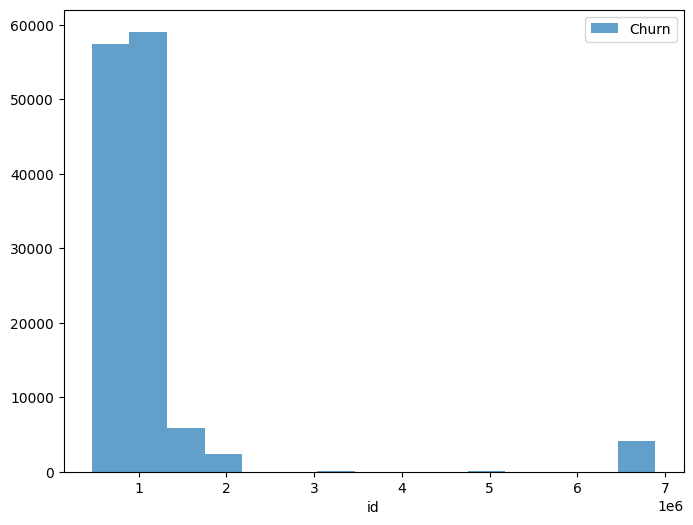

no churn:
count    3.925900e+04
mean     1.028483e+06
std      3.798352e+05
min      5.333620e+05
5%       5.977923e+05
25%      7.942150e+05
50%      9.888450e+05
75%      1.174931e+06
90%      1.496067e+06
95%      1.940009e+06
99%      1.956089e+06
max      6.879764e+06
Name: id, dtype: float64


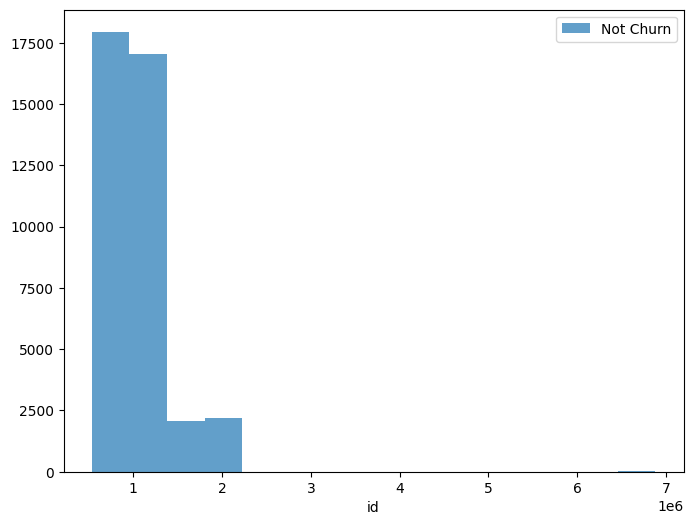

-----------inception_date-----------
churn:
count    129076.000000
mean          0.808809
std           0.139918
min           0.000000
5%            0.522019
25%           0.803901
50%           0.806372
75%           0.893125
90%           0.955520
95%           0.979966
99%           0.996293
max           1.000000
Name: inception_date, dtype: float64


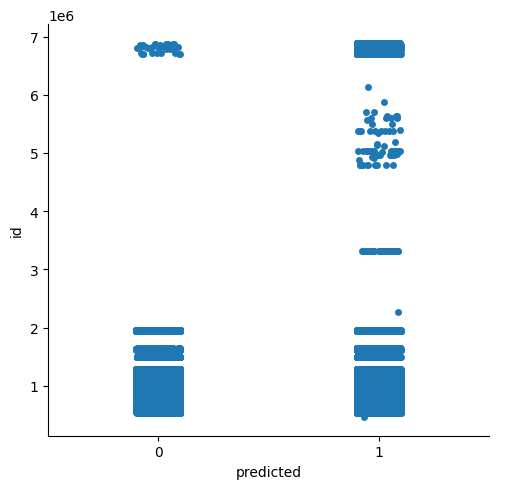

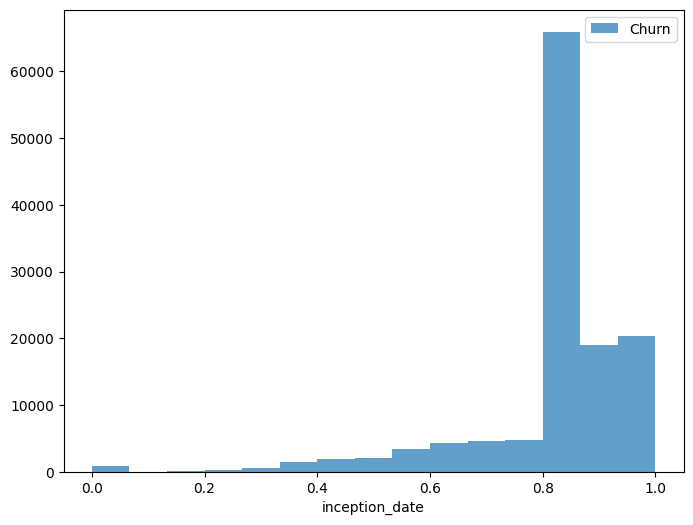

no churn:
count    39259.000000
mean         0.764557
std          0.119505
min          0.153914
5%           0.508419
25%          0.769041
50%          0.803901
75%          0.803901
90%          0.867532
95%          0.903980
99%          0.954549
max          0.998941
Name: inception_date, dtype: float64


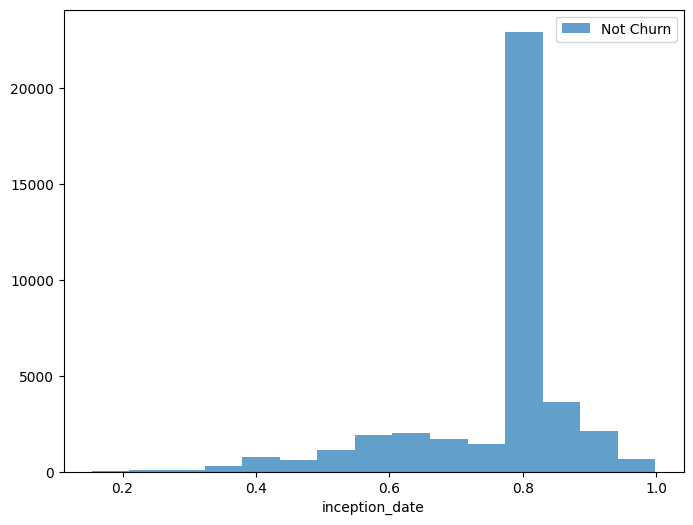

-----------deceased_fair_market_value-----------
churn:
count    129076.000000
mean          0.001331
std           0.478079
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%           0.000000
max         171.760000
Name: deceased_fair_market_value, dtype: float64


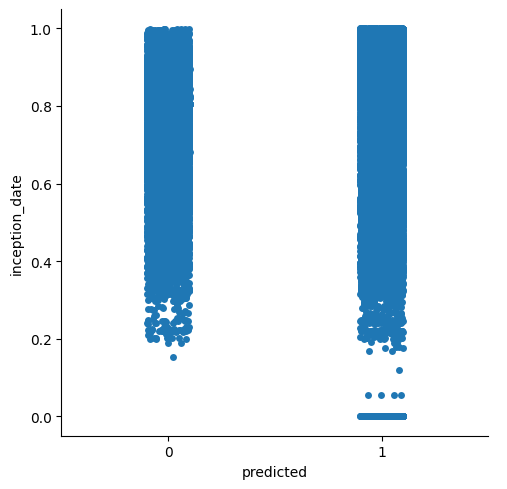

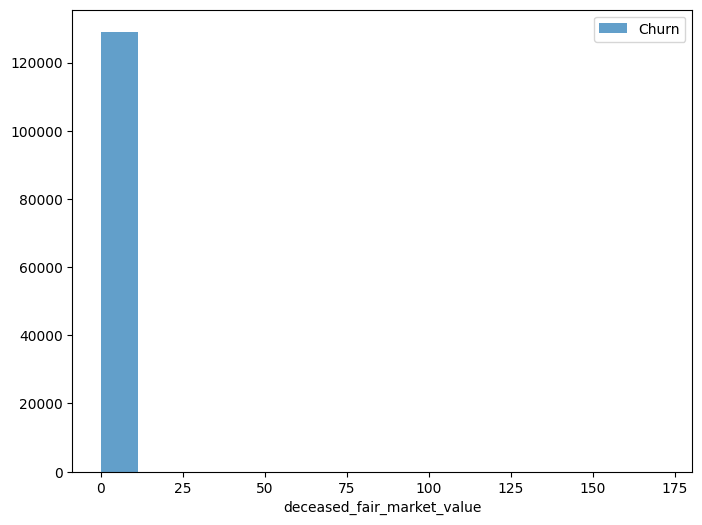

no churn:
count    39259.000000
mean         9.998570
std        109.986591
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
95%          0.000000
99%        459.784200
max      11156.310000
Name: deceased_fair_market_value, dtype: float64


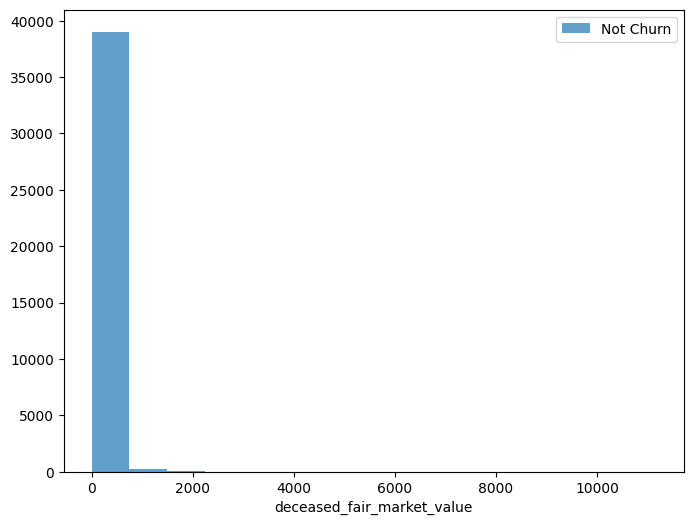

-----------rrif_original_date-----------
churn:
count    129076.000000
mean          0.333627
std           0.425751
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.842187
90%           0.934943
95%           0.965909
99%           0.994034
max           1.000000
Name: rrif_original_date, dtype: float64


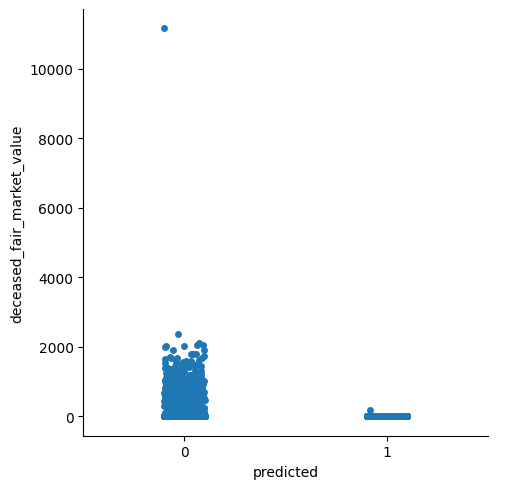

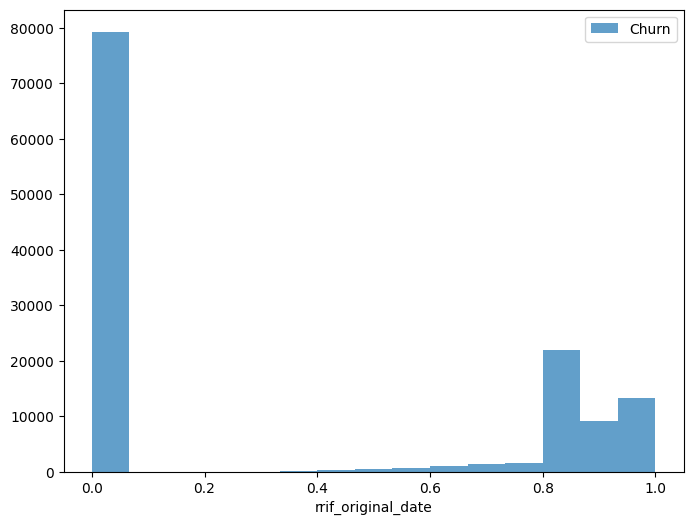

no churn:
count    39259.000000
mean         0.796154
std          0.115817
min          0.000000
5%           0.533239
25%          0.764418
50%          0.842187
75%          0.842187
90%          0.892202
95%          0.922088
99%          0.963210
max          0.999148
Name: rrif_original_date, dtype: float64


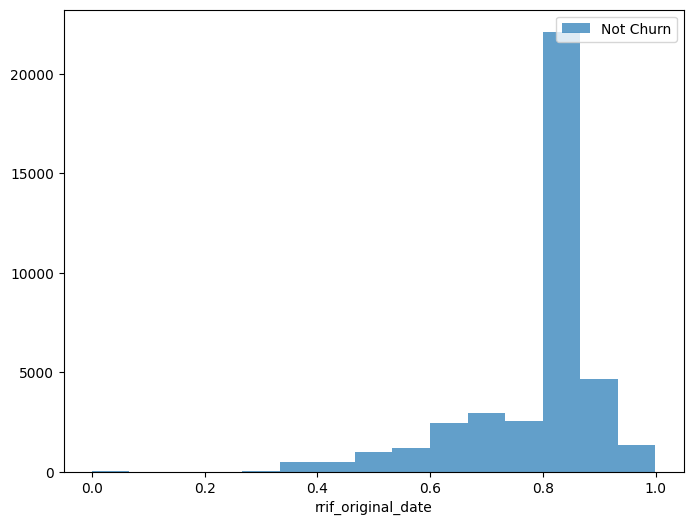

-----------updated_at-----------
churn:
count    129076.000000
mean          0.841574
std           0.066045
min           0.000000
5%            0.835465
25%           0.835465
50%           0.835465
75%           0.860734
90%           0.860734
95%           0.861681
99%           0.912593
max           1.000000
Name: updated_at, dtype: float64


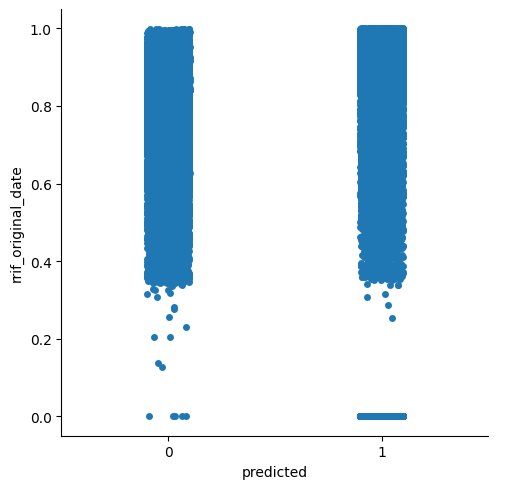

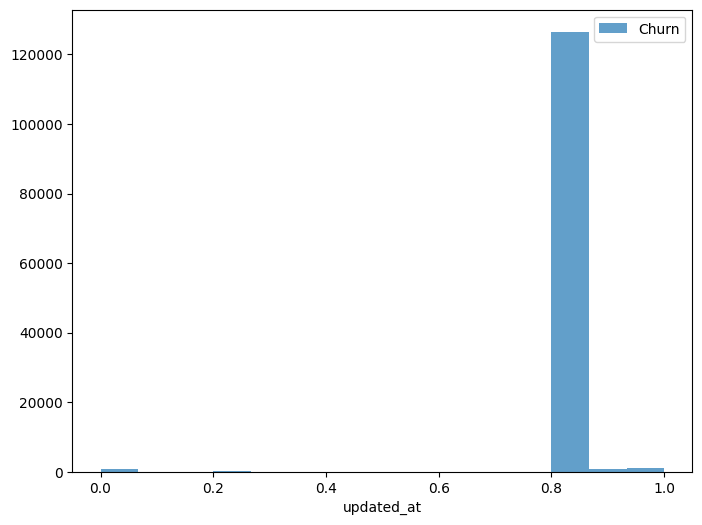

no churn:
count    39259.000000
mean         0.861334
std          0.007513
min          0.835465
5%           0.860734
25%          0.860734
50%          0.860734
75%          0.860734
90%          0.860734
95%          0.861657
99%          0.861742
max          1.000000
Name: updated_at, dtype: float64


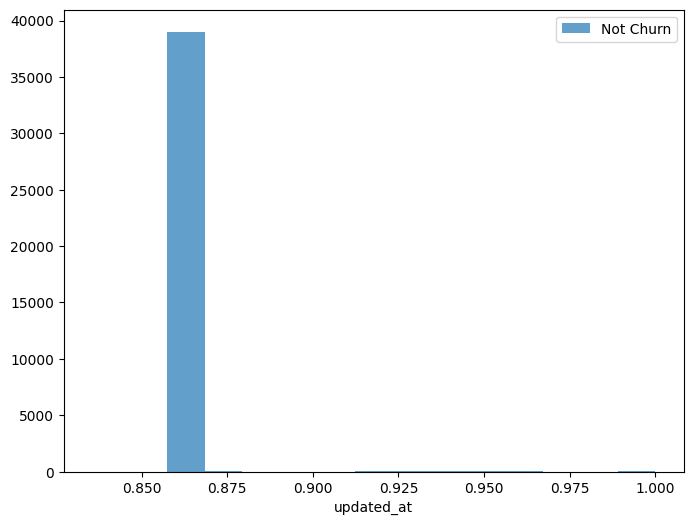

-----------retail_last_maintenance_time-----------
churn:
count    129076.000000
mean          0.355300
std           0.450987
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.914149
90%           0.972627
95%           0.987025
99%           0.997689
max           1.000000
Name: retail_last_maintenance_time, dtype: float64


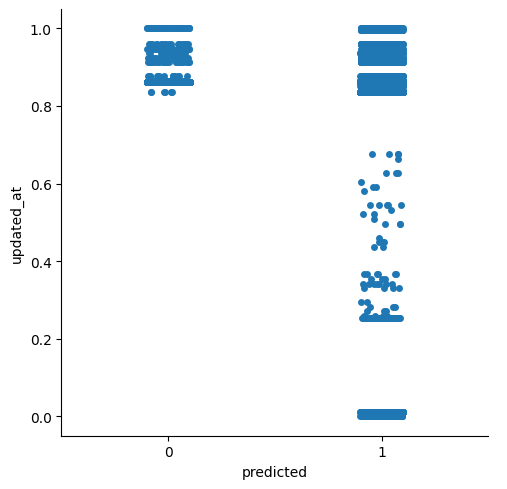

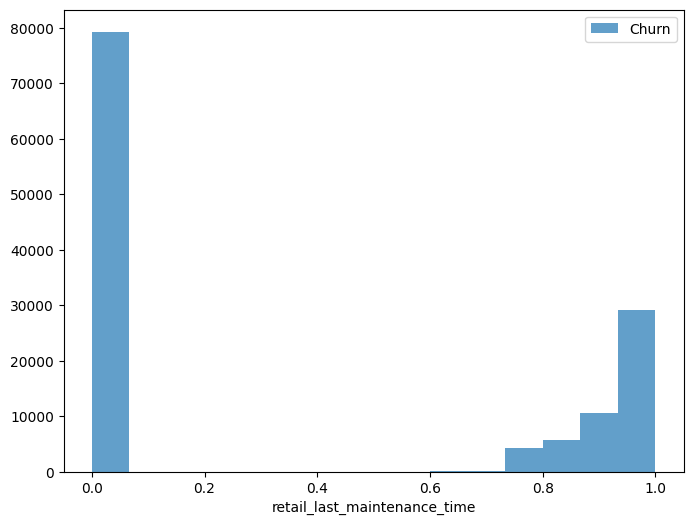

no churn:
count    39259.000000
mean         0.802733
std          0.156334
min          0.000000
5%           0.448276
25%          0.708319
50%          0.841984
75%          0.928368
90%          0.970494
95%          0.986669
99%          0.996978
max          1.000000
Name: retail_last_maintenance_time, dtype: float64


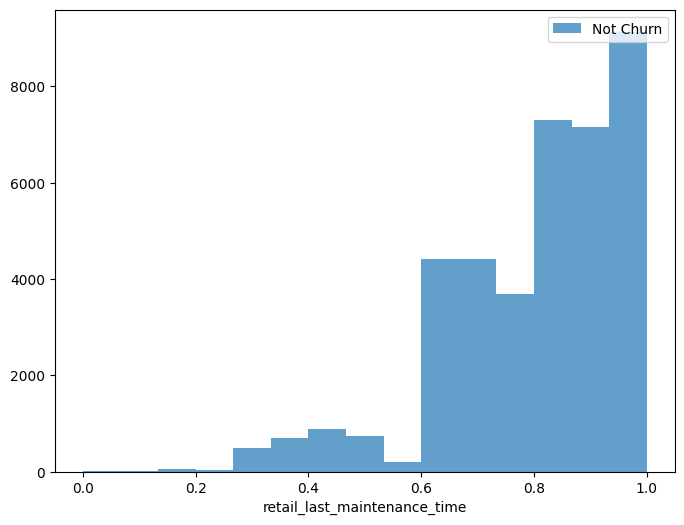

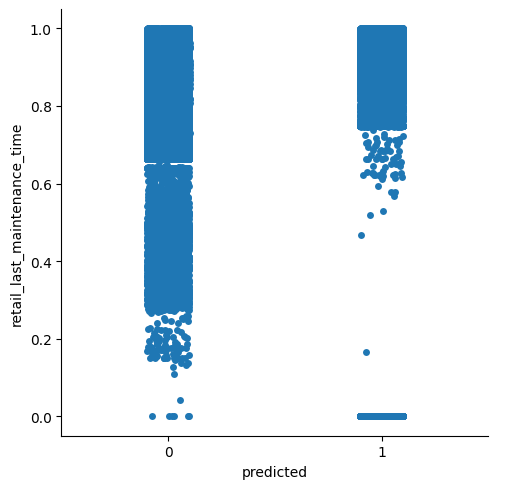

In [ ]:
# Analysis for numeric variables
# Function to summarize distribution for numerical values for a feature using column charts and percentiles
def func_num(col_name):
    print('-----------' + col_name + '-----------')

    filtered_churn_df = churn_df[churn_df[col_name] != -999]

    print('churn:')
    print(filtered_churn_df[col_name].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99]))
    plt.figure(figsize=(8,6))
    plt.xlabel(col_name)
    plt.hist(filtered_churn_df[col_name], bins=15, alpha=0.7, label='Churn')
    plt.legend(loc='upper right')
    plt.show()

    filtered_no_churn_df = no_churn_df[no_churn_df[col_name] != -999]

    print('no churn:')
    print(filtered_no_churn_df[col_name].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99]))
    plt.figure(figsize=(8,6))
    plt.xlabel(col_name)
    plt.hist(filtered_no_churn_df[col_name], bins=15, alpha=0.7, label='Not Churn')
    plt.legend(loc='upper right')
    plt.show()

    filtered_df_eda = df_eda[df_eda[col_name] != -999]
    sns.catplot(x = "predicted", y = col_name, data=filtered_df_eda)

for col in numeric_variables:
    func_num(col)

### 5.0 Save To Submission

In [ ]:
prediction_df['predicted'] = prediction_df['predicted'].map({0: 'no churn', 1: 'churn'})
prediction_df = prediction_df[['id', 'predicted']]
# Fill in location for saving csv
prediction_df.to_csv('submission.csv')